# Generative modelling in deep learning

### Maxence Gélard
maxence.gelard@student-cs.fr

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

> Let $\mathcal{Z}$ be the support of the two distributions $p_D$ and $p_\theta$.
>
> - In order to compare two given distributions $p_D$ and $p_\theta$, we have seen during the lecture than a common   way is to use the **Kullback-Leibler divergence** defined as:
>
>    $KL(p_D || p_\theta) = - \int_{\mathcal{Z}} log\left(\frac{p_{\theta}(z)}{p_D(z)}\right)p_{D}(z) dz$
>
>    Using, this measure (which is not properly a distance as it is not symmetric), the two distributions $p_D$ and  $p_\theta$ will be considered similar when $KL(p_D || p_\theta)$ is close to $0$.
>    
>
>- **Kolmogorov-Smirnov** distance: given the respective cumulative distribution functions $F_D$ and $F_\theta$ of  $p_D$ and $p_\theta$, we define the **Kolmogorov-Smirnov** distance as:
>    
>    $D_{KS}(F_D, F_\theta) = \sup_{z \in \mathcal{Z}} |F_{D}(z) - F_{\theta}(z)| $
>    
>
>- Using the kernels method theory, we can also define the **Maximum Mean Discrepancy** in the Reproducing Kernel  Hilbert Space $\mathcal{H}$ associated to a kernel $K$ by:
>
>   $MMD(p_D, p_\theta) = || \mu_{p_D} - \mu_{p_\theta}||_{\mathcal{H}}$
>    With, for a given distribution $p$: $\forall z \in \mathcal{Z}, \mu_p(z) = \mathbb{E}_{x \sim p}\left[K(x, z)\right]$. $\mu_p$ is called the mean embedding of $p$ and "summarizes" $p$.
>    
>    I have learnt about this last metric during the "Kernels Methods" course in MVA (source: https://mva-kernel->methods.github.io/course-2021-2022/)

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

>- **Compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$)**: The main issue with methods that directly 
aim at comparing the density of the distribution is the ability to acutally being able to evaluate these densities at any given point $x$. This is actually often intractable for $p_D$ as we only have access to samples (datasets) in most time, and $p_\theta$ may also become intractable when dealing with high dimensional spaces.
>
>
>- **compare the values sampled from the distributions**: Methods based on comparing samples first require to design a sampling method, which is not always easy. For example, we would need to use techniques like rejection sampling to be able to sample from a distribution that we would only know up to a constant. Then, if we want to sample from a distribution for example to estimate expectation, simple Monte-Carlo estimates may suffer from high variance (methods like importance sampling may be able to reduce this variance). Finally, it is not always straightforward to compare distributions when we are only given samples (for example estimating the expectations from samples may not be enough to compare two Gaussian distributions that have the same mean).

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strengths and weaknesses.

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise $\epsilon$?**

> As $N$ increases, we are going to sample from a higher dimensional Gaussian distribution, which means that we increase the number of degrees of freedom of the function $f_\theta$ learnt by the neural network, leading to potentially better generated datapoints. Nevertheless, high dimensional latent space may lead to a network that will be more difficult to train, or at least that will take longer to be trained.

By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that for the generator fixed, the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$
, where JSD is the JS divergence used to measure the similarity of two distributions. 
$$JSD(p_\theta \| p_D) = \frac{1}{2} \mathbb{E}_{p_D} \left[ log(\frac{2p_D}{p_D+p_\theta}) \right] + \frac{1}{2} \mathbb{E}_{p_\theta} \left[ log(\frac{2p_\theta}{p_D+p_\theta}) \right]$$
So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

> In the case where the discriminator $D$ has good performance / is expressive enough, i.e correctly classifies true from generated data, then the loss $\mathcal{L}_D$ can saturates and thus lead to vanishing gradients, which will prevent the generator from having enough feedback to be trained. This can be the case for example when $p_D$ and $p_\theta$ are really different, making it easy for $D$ to discriminate between real and fake data, but the saturation of $\mathcal{L}_D$ prevents from backpropagating the feedback.

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

> As this loss only gives feedback to the generator on samples it generated, it will only be able to improve the generation quality on the "type" of sampled it generated and not on the others: this is the problem of "modes drop". Let's for example consider the example of a dataset that consists of dogs and cats. If the generator only provide samples from cats, it will have feedback on these samples and finally be able to generate cats well. However, the learnt distribution $p_\theta$ will never truly correspond to $p_D$ as it will never have learnt to generate dogs.

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D two-moons shape with some noise.

In [1]:
from typing import Dict

import torch
import math
from sklearn import datasets
import numpy as np

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the dataset
    """
    data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
    return torch.from_numpy(data)

Let's plot a large batch, to see what the dataset looks like.

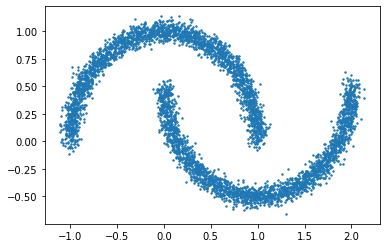

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(5000)

plt.scatter(batch[:,0], batch[:,1], s=2.0)
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [3]:
import torch.nn as nn
import torch.nn.functional as F

activation = nn.ReLU()

# Define the generator
class Generator(nn.Module):
    def __init__(self, n_hidden_layers, n_neurons, prior_n):
        super().__init__()
        self.prior_n = prior_n
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(prior_n, n_neurons))
        for _ in range(n_hidden_layers):
            self.layers.append(nn.Linear(n_neurons, n_neurons)) 
        self.layers.append(nn.Linear(n_neurons, 2))
        
    def __call__(self, z):
        for i in range(len(self.layers) - 1):
            z = self.layers[i](z)
            z = activation(z)
        
        return self.layers[-1](z)
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, self.prior_n), 1.0)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self, n_hidden_layers, n_neurons):
        super().__init__()
        
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(2, n_neurons))
        for _ in range(n_hidden_layers):
            self.layers.append(nn.Linear(n_neurons, n_neurons)) 
        self.layers.append(nn.Linear(n_neurons, 1))
    
    def __call__(self, x):
        for i in range(len(self.layers) - 1):
            x = self.layers[i](x)
            x = activation(x)
        
        return self.layers[-1](x)

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

In [4]:
def run_gan_experiment(experiment_parameters: Dict[str, int], benchmark:bool = True):
    # Number of times to train the discriminator between two generator steps
    TRAIN_RATIO = experiment_parameters["train_ratio"]
    # Total number of training iterations for the generator
    N_ITER = experiment_parameters["n_iter"]
    # Batch size to use
    BATCHLEN = experiment_parameters["batch_len"]    
    
    generator = Generator(
        experiment_parameters["n_hidden_layers_gen"],
        experiment_parameters["n_neurons_gen"],
        experiment_parameters["prior_n"],
    )
    optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
    discriminator = Discriminator(
        experiment_parameters["n_hidden_layers_dis"],
        experiment_parameters["n_neurons_dis"],
    )
    optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))

    soft_plus = torch.nn.functional.softplus
    disc_losses = []
    gen_losses = []

    for i in range(N_ITER):
        # train the discriminator
        for k in range(TRAIN_RATIO):
            discriminator.zero_grad()
            real_batch = generate_batch(BATCHLEN)
            fake_batch = generator.generate(BATCHLEN)
            #
            # == COMPUTE THE DISCRIMINATOR LOSS HERE ==
            #
            discrimator_real_logits = discriminator(real_batch)
            discrimator_fake_logits = discriminator(fake_batch)
            # Justification of the use of soft_plus(x) = log(1 + exp(x)):
            # E[-log(D(x))] = E[-log(sigmoid(discriminator(x)))]
            #               = E[-log(1 / (1 + exp(-discriminator(x))))]
            #               = E[soft_plus(-discriminator(x))] (same for the other term)
            # this reformulation is a current trick and is for example
            # derived in https://arxiv.org/pdf/1606.03498.pdf
            disc_loss = (soft_plus(-discrimator_real_logits) + soft_plus(discrimator_fake_logits)).mean()
            # the mean is taken on the batch dimension
            disc_loss.backward()
            optim_disc.step()
            
            
            if k == TRAIN_RATIO - 1:
                # we look at the discriminator loss after having trained in
                # TRAIN_RATIO times
                disc_losses.append(disc_loss.item())
            
        # train the generator
        generator.zero_grad()
        fake_batch = generator.generate(BATCHLEN)
        #
        # == COMPUTE THE GENERATOR LOSS HERE
        #
        discrimator_fake_logits = discriminator(fake_batch)
        gen_loss = soft_plus(-discrimator_fake_logits).mean()
        gen_loss.backward()
        optim_gen.step()
        gen_losses.append(gen_loss.item())
        if i%1000 == 0 and not benchmark:
            print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
            # plot the result
            real_batch = generate_batch(1024)
            fake_batch = generator.generate(1024).detach()
            plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
            plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
            plt.legend()
            plt.show()
    return disc_losses, gen_losses

step 0: discriminator: 1.365e+00, generator: 7.085e-01


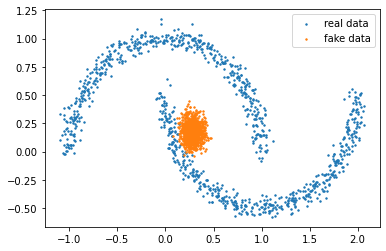

step 1000: discriminator: 1.151e+00, generator: 9.527e-01


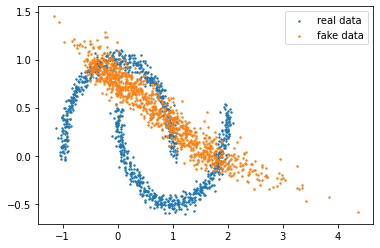

step 2000: discriminator: 1.244e+00, generator: 8.791e-01


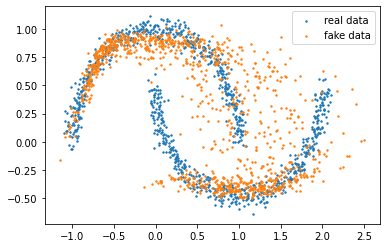

step 3000: discriminator: 1.366e+00, generator: 6.771e-01


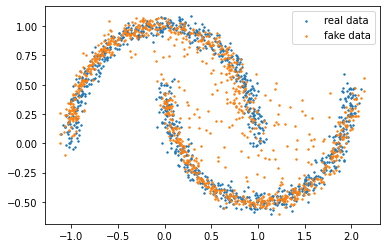

step 4000: discriminator: 1.379e+00, generator: 7.406e-01


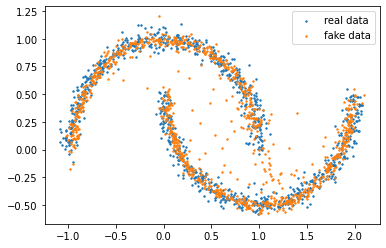

In [5]:
experiment_param = {
    "train_ratio": 1,
    "n_iter": 5000,
    "batch_len": 128,
    "n_hidden_layers_gen": 1,
    "n_neurons_gen": 256,
    "prior_n": 100,
    "n_hidden_layers_dis": 1,
    "n_neurons_dis": 256,
}
disc_losses, gen_losses = run_gan_experiment(experiment_param, benchmark=False)

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

> When the discriminator is trained well, it will tend to always predict $D(x) = 0$ for $x \sim p_\theta$. In this case, $\mathcal{L}_G = 0$, which is unexpected as we would expect the generator loss to be high when the discriminator is able to detect fake data. In the case where the discriminator would always output the wrong label, i.e it predicts $D(x) = 1$ for fake data, $\mathcal{L}_G$ can take very large negative values. This means that when we have a bad discirminator, we can make the loss lower, which would indicate the generator the wrong feedback. 

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ to avoid gradient vanishing.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`


I have been encapsulating the proposed code to train a GAN in the `run_gan_experiment` function in order to be able to run some benchmarks on the different parameters

**Impact of `TRAIN_RATIO`**

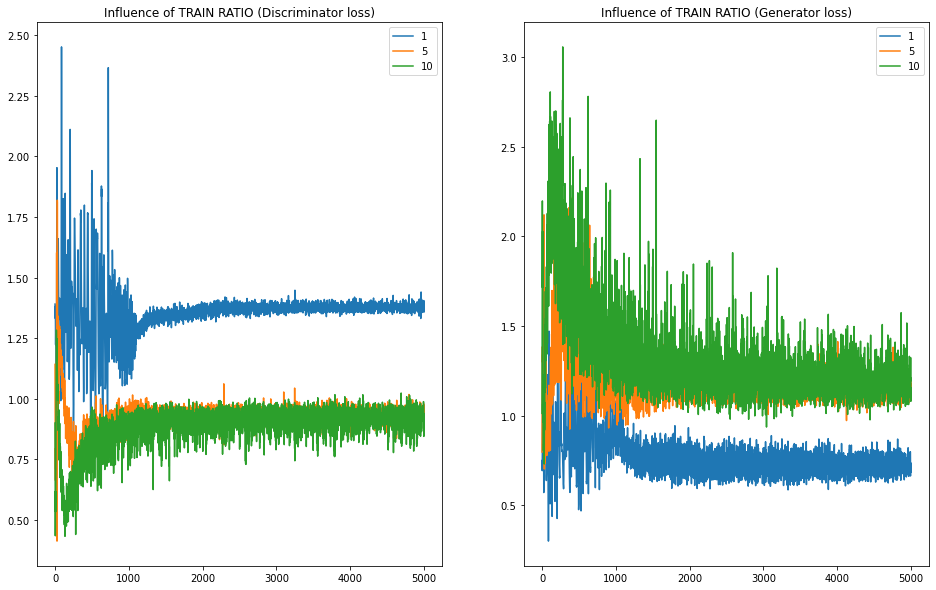

In [6]:
experiment_param = {
    "train_ratio": 1,
    "n_iter": 5000,
    "batch_len": 128,
    "n_hidden_layers_gen": 1,
    "n_neurons_gen": 256,
    "prior_n": 100,
    "n_hidden_layers_dis": 1,
    "n_neurons_dis": 256,
}

results_train_ratio = {"gen_losses": [], "dis_losses": []}

for train_ratio in [1, 5, 10]:
    experiment_param["train_ratio"] = train_ratio
    disc_losses, gen_losses = run_gan_experiment(experiment_param, benchmark=True)
    results_train_ratio["dis_losses"].append(disc_losses)
    results_train_ratio["gen_losses"].append(gen_losses)

colors = {1: "r", 5: "b", 10: "g"}
fig, ax = plt.subplots(1, 2, figsize=(16, 10))

plt.subplot(1, 2, 1)
for i, train_ratio in enumerate([1, 5, 10]):
    plt.plot(results_train_ratio["dis_losses"][i], label=train_ratio)
plt.title("Influence of TRAIN RATIO (Discriminator loss)")
plt.legend()

plt.subplot(1, 2, 2)
for i, train_ratio in enumerate([1, 5, 10]):
    plt.plot(results_train_ratio["gen_losses"][i], label=train_ratio)
plt.title("Influence of TRAIN RATIO (Generator loss)")
plt.legend()

> One can observe that increasing `TRAIN_RATIO` allows to smooth the training of the discriminator, which is not surprising as it means that we train it more times before switching to the optimization of the generator. We can also see that it leads to a smaller loss after the same number of iterations (still for the discriminator). However, increasing this parameters leads to a higher loss for the generator, which is explainable by the analysis we have made previously, where a too good discriminator can lead to vanishing gradients for the generator training. Nevertheless, a too small `TRAIN_RATIO` can lead to a case where the discriminator loss increases over the epoch, while the genetors' one discreases.

**Impact of Generator depth**

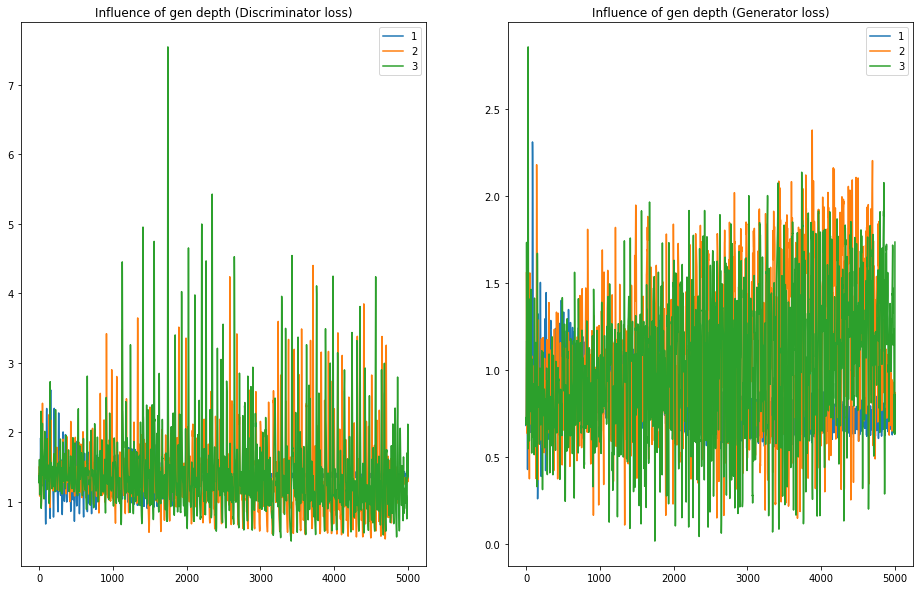

In [7]:
experiment_param = {
    "train_ratio": 1,
    "n_iter": 5000,
    "batch_len": 128,
    "n_hidden_layers_gen": 1,
    "n_neurons_gen": 256,
    "prior_n": 100,
    "n_hidden_layers_dis": 1,
    "n_neurons_dis": 256,
}

results_gen_depth = {"gen_losses": [], "dis_losses": []}

for n_hidden_layers_gen in [1, 2, 3]:
    experiment_param["n_hidden_layers_gen"] = n_hidden_layers_gen
    disc_losses, gen_losses = run_gan_experiment(experiment_param, benchmark=True)
    results_gen_depth["dis_losses"].append(disc_losses)
    results_gen_depth["gen_losses"].append(gen_losses)

colors = {1: "r", 2: "b", 3: "g"}
fig, ax = plt.subplots(1, 2, figsize=(16, 10))

plt.subplot(1, 2, 1)
for i, n_hidden_layers_gen in enumerate([1, 2, 3]):
    plt.plot(results_gen_depth["dis_losses"][i], label=n_hidden_layers_gen)
plt.title("Influence of gen depth (Discriminator loss)")
plt.legend()

plt.subplot(1, 2, 2)
for i, n_hidden_layers_gen in enumerate([1, 2, 3]):
    plt.plot(results_gen_depth["gen_losses"][i], label=n_hidden_layers_gen)
plt.title("Influence of gen depth (Generator loss)")
plt.legend()

**Impact of Generator width**

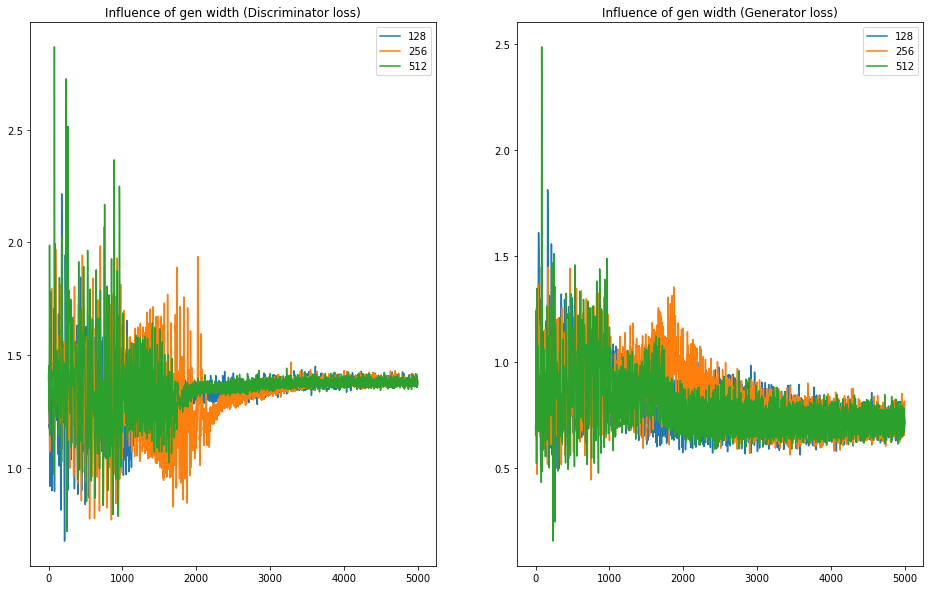

In [8]:
experiment_param = {
    "train_ratio": 1,
    "n_iter": 5000,
    "batch_len": 128,
    "n_hidden_layers_gen": 1,
    "n_neurons_gen": 256,
    "prior_n": 100,
    "n_hidden_layers_dis": 1,
    "n_neurons_dis": 256,
}

results_gen_width = {"gen_losses": [], "dis_losses": []}

for n_neurons_gen in [128, 256, 512]:
    experiment_param["n_neurons_gen"] = n_neurons_gen
    disc_losses, gen_losses = run_gan_experiment(experiment_param, benchmark=True)
    results_gen_width["dis_losses"].append(disc_losses)
    results_gen_width["gen_losses"].append(gen_losses)

fig, ax = plt.subplots(1, 2, figsize=(16, 10))

plt.subplot(1, 2, 1)
for i, n_neurons_gen in enumerate([128, 256, 512]):
    plt.plot(results_gen_width["dis_losses"][i], label=n_neurons_gen)
plt.title("Influence of gen width (Discriminator loss)")
plt.legend()

plt.subplot(1, 2, 2)
for i, n_neurons_gen in enumerate([128, 256, 512]):
    plt.plot(results_gen_width["gen_losses"][i], label=n_neurons_gen)
plt.title("Influence of gen width (Generator loss)")
plt.legend()

> One can observe that increasing the generator width or depth can make the training of both the generator and discriminator more unstable. This looks to be especially true for the depth, so we would recommand not to have a to deep generator, even if it helps providing expressivity to the network.

**Impact of Discrimator depth**

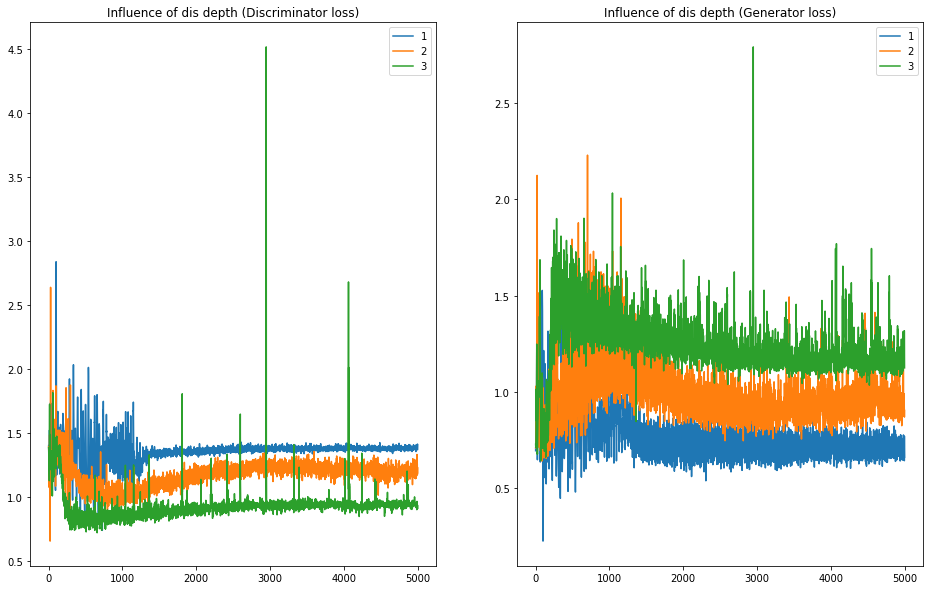

In [9]:
experiment_param = {
    "train_ratio": 1,
    "n_iter": 5000,
    "batch_len": 128,
    "n_hidden_layers_gen": 1,
    "n_neurons_gen": 256,
    "prior_n": 100,
    "n_hidden_layers_dis": 1,
    "n_neurons_dis": 256,
}

results_dis_depth = {"gen_losses": [], "dis_losses": []}

for n_hidden_layers_dis in [1, 2, 3]:
    experiment_param["n_hidden_layers_dis"] = n_hidden_layers_dis
    disc_losses, gen_losses = run_gan_experiment(experiment_param, benchmark=True)
    results_dis_depth["dis_losses"].append(disc_losses)
    results_dis_depth["gen_losses"].append(gen_losses)

fig, ax = plt.subplots(1, 2, figsize=(16, 10))

plt.subplot(1, 2, 1)
for i, n_hidden_layers_dis in enumerate([1, 2, 3]):
    plt.plot(results_dis_depth["dis_losses"][i], label=n_hidden_layers_dis)
plt.title("Influence of dis depth (Discriminator loss)")
plt.legend()

plt.subplot(1, 2, 2)
for i, n_hidden_layers_dis in enumerate([1, 2, 3]):
    plt.plot(results_dis_depth["gen_losses"][i], label=n_hidden_layers_dis)
plt.title("Influence of dis depth (Generator loss)")
plt.legend()

**Impact of Generator width**

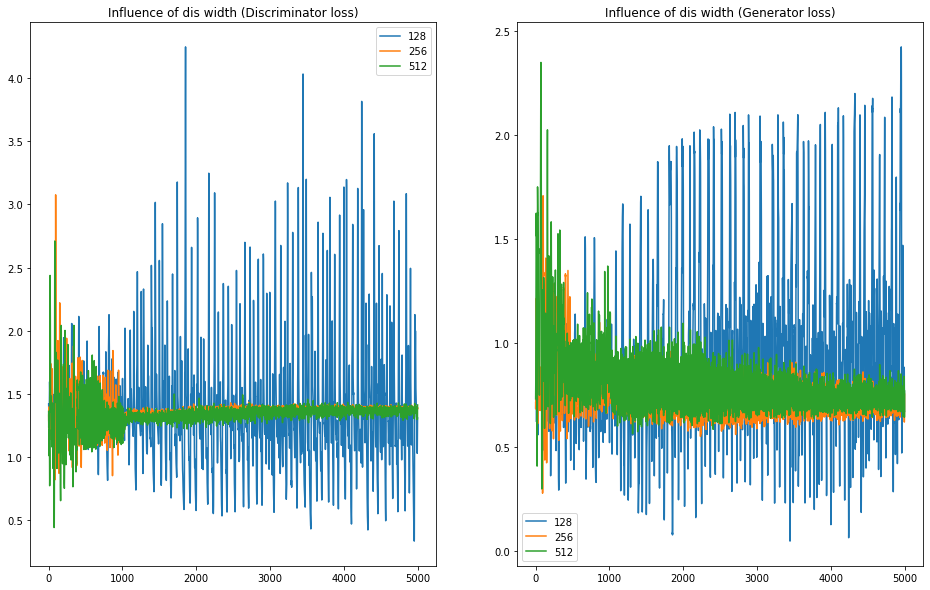

In [10]:
experiment_param = {
    "train_ratio": 1,
    "n_iter": 5000,
    "batch_len": 128,
    "n_hidden_layers_gen": 1,
    "n_neurons_gen": 256,
    "prior_n": 100,
    "n_hidden_layers_dis": 1,
    "n_neurons_dis": 256,
}

results_dis_width = {"gen_losses": [], "dis_losses": []}

for n_neurons_dis in [128, 256, 512]:
    experiment_param["n_neurons_dis"] = n_neurons_dis
    disc_losses, gen_losses = run_gan_experiment(experiment_param, benchmark=True)
    results_dis_width["dis_losses"].append(disc_losses)
    results_dis_width["gen_losses"].append(gen_losses)

fig, ax = plt.subplots(1, 2, figsize=(16, 10))

plt.subplot(1, 2, 1)
for i, n_neurons_dis in enumerate([128, 256, 512]):
    plt.plot(results_dis_width["dis_losses"][i], label=n_neurons_dis)
plt.title("Influence of dis width (Discriminator loss)")
plt.legend()

plt.subplot(1, 2, 2)
for i, n_neurons_dis in enumerate([128, 256, 512]):
    plt.plot(results_dis_width["gen_losses"][i], label=n_neurons_dis)
plt.title("Influence of dis width (Generator loss)")
plt.legend()

> Increasing the depth and width of the discriminator have kind of a similar effect that playing on `TRAIN_RATIO` in the sense that it allows to have a more expressive discriminator, whose loss converges to a lower values (namely while increasing the depth of the discriminator), but with the drawback that the training of the generator is way more unstable, and leads to a higher loss. This might be due to the same issue that having a too good discriminator can lead to difficulties in the generator training because of vanishing gradients.

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)
- A Style-Based Generator Architecture for Generative Adversarial Networks *(Karras et al.)* [arxiv:1812.04948v3](https://arxiv.org/abs/1812.04948v3)

### Variational AutoEncoders

Another well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.
$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]$$

**Q8: Prove this equivalence.**

>$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]
                         = \mathbb{E}_{p_D}\left[ log(p_D) \right] - \mathbb{E}_{p_D}\left[ log(p_\theta) \right]
$.
> The optimization is done with respect to the variable $\theta$. So the term $\mathbb{E}_{p_D}\left[ log(p_D) \right]$ is constant in this optimization problem. Therefore, maximize $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$ is equivalent to minimize  $-\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$, which is equivalent to minimize $\mathbb{E}_{p_D}\left[ log(p_D) \right] - \mathbb{E}_{p_D} \left[\log p_\theta(x) \right ] = D_{KL}(p_D \| p_\theta)$

However, the classes of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution as: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)dz$ is an infinite mixture of Gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce another, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms forms a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

![VAE](vae-gaussian.png)

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

> Initially, we want to be able to generate data using the VAE by passing to the decoder a sample $z \sim p(z)$.       However, in order to make $p_{\theta}(x)$ tractable, we have been introducing the auxiliary density $q_\phi$, from   which we sample during the training process. That means that after training, if we sample $z$ from $p(z)$, we do not have any guarantee that the data point $x'$ that will be generate will indeed correspond to a point that look like a  sample from $p_D$. Nevertheless, the term $D_{KL}(q_\phi(z | x) \| p(z))$ can be interpreted as a regularizer to     enforce the approximate posterior (of the latent variable) to be close to the prior. Therefore, the problem we could  have when generating data from $p_z$ might be very limited after training. 

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

> For this question, I found some help in the Probabilisitc Graphical Models course (MVA) by Pierre-Alexandre Mattei and from https://mr-easy.github.io/2020-04-16-kl-divergence-between-2-gaussian-distributions/
>
> Let's denote $m$ the dimension of the latent space. Let's also, for notation purposes, do the calculation of $D_{KL}(p||q))$, where $p = \mathcal{N}(\mu_1, \Sigma_1)$ and $q = \mathcal{N}(\mu_1, \Sigma_1)$. So means of $p$ and $q$ are vectors of dimension $m$, and their covariance matrices are square-matrices of size $m \times m$.
>
> We recall the formula of the Gaussian density: 
$p(x) = \frac{1}{(2\pi)^{m/2}|\Sigma_1|^{1/2}}exp(-\frac{1}{2}(x - \mu_1)^T \Sigma_1^{-1} (x - \mu_1))$
>
>
>$D_{KL}(p||q)) = \mathbb{E}_p\left[log(p(x)) - log(q(x))\right] = -\frac{1}{2}\mathbb{E}_p\left[(x - \mu_1)^T \Sigma_1^{-1}(x - \mu_1) \right] + \frac{1}{2}\mathbb{E}_p\left[log(\frac{|\Sigma_{2}|}{|\Sigma_{1}|})\right] -\frac{1}{2}\mathbb{E}_p\left[(x - \mu_2)^T \Sigma_2^{-1}(x - \mu_2) \right] $.
>
>For the first term, we recognize, as the quantity insde the expectation is a scalar, the latter is equal to its trace, and using the fact that we can commute pairs of matrices inside the trace operator: 
$\frac{1}{2}\mathbb{E}_p\left[(x - \mu_1)^T \Sigma_1^{-1}(x - \mu_1) \right] = \frac{1}{2} Tr(\mathbb{E}_{p}\left[(x - \mu_1)^T (x - \mu_1)\right] \Sigma_1^{-1}) = \frac{1}{2} Tr(\Sigma_1 \Sigma_1^{-1}) = \frac{m}{2}$.
>
>The second term does not depend on any sampling from $p$, so: 
$\frac{1}{2}\mathbb{E}_p\left[log(\frac{|\Sigma_{2}|}{|\Sigma_{1}|})\right] = \frac{1}{2}log(\frac{|\Sigma_{2}|}{|\Sigma_{1}|})$.
>
>For the third term, some matrices manipulations lead to:
$\mathbb{E}_p\left[(x - \mu_2)^T \Sigma_2^{-1}(x - \mu_2) \right] = (\mu_1 - \mu_2)^T \Sigma_2^{-1}(\mu_1 - \mu_2) + Tr(\Sigma_2^{-1}\Sigma_1)$
>
>Finally: $D_{KL}(p||q)) = \frac{1}{2}\left[log(\frac{|\Sigma_{2}|}{|\Sigma_{1}|}) - m + (\mu_1 - \mu_2)^T \Sigma_2^{-1}(\mu_1 - \mu_2) + Tr(\Sigma_2^{-1}\Sigma_1) \right]$
>
>
>Here, we have: $q_\phi(z | x) = \mathcal{N}(\mu_\phi(x), Diag(\sigma_\phi^2(x)))$ and $p(z) = \mathcal{N}(0, Id)$.
Therefore:
>
>$D_{KL}(q_\phi(z | x) \| p(z)) = \frac{1}{2} \left[\mu_\phi(x)^T \mu_\phi(x) + Tr(Diag(\sigma_\phi^2(x)) - m - log(|Diag(\sigma_\phi^2(x)|) \right]$

We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$.


**Note:** For the following, be careful about the difference between $\mu_\phi, \sigma_\phi$ which define the Gaussian distribution of the *encoder* $q_\phi$ and $\mu_\theta, \sigma_\theta$ which define the Gaussian distribution of the *decoder* $p_\theta$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

> The model which is chosen is : $p_\theta(x | z) = \mathcal{N}(x ; \mu_\theta(z), Diag(\sigma_\theta^2(z))) 
= \frac{1}{(2\pi)^{m/2}|Diag(\sigma_\theta^2(z))|^{1/2}}exp(-\frac{1}{2}(x - \mu_\theta(z))^T Diag(\sigma_\theta^2(z))^{-1} (x - \mu_\theta(z)))$.
>
>So $\log p_\theta(x | z) = log\left(\frac{1}{(2\pi)^{m/2}|Diag(\sigma_\theta^2(z))|^{1/2}}\right) -\frac{1}{2}(x - \mu_\theta(z))^T Diag(\sigma_\theta^2(z))^{-1} (x - \mu_\theta(z))$.
>
>And: $-\log p_\theta(x | z) = \frac{1}{2}log((2\pi)^{m}|Diag(\sigma_\theta^2(z))|) + \frac{1}{2}(x - \mu_\theta(z))^T Diag(\sigma_\theta^2(z))^{-1} (x - \mu_\theta(z))$

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [11]:
# Choose a value for the latent dimension
# LATENT_N = 10 -> it will be parametrized in a function used to build and train the VAE

activation = nn.ReLU()

# Define the generator
class Encoder(nn.Module):
    def __init__(self, n_hidden_layers, n_neurons, latent_n):
        super().__init__()    
        self.latent_n = latent_n
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(2, n_neurons))
        for _ in range(n_hidden_layers):
            self.layers.append(nn.Linear(n_neurons, n_neurons)) 
        self.layers.append(nn.Linear(n_neurons, 2 * latent_n))
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        for i in range(len(self.layers) - 1):
            x = self.layers[i](x)
            x = activation(x)
    
        x = self.layers[-1](x)
        mu, logvar = torch.split(x, split_size_or_sections=self.latent_n, dim=1)
        return (mu, logvar)
    

# Define the discriminator
class Decoder(nn.Module):
    def __init__(self, n_hidden_layers, n_neurons, latent_n):
        super().__init__()        
        self.latent_n = latent_n
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(latent_n, n_neurons))
        for _ in range(n_hidden_layers):
            self.layers.append(nn.Linear(n_neurons, n_neurons)) 
        self.layers.append(nn.Linear(n_neurons, 2 * 2))
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        for i in range(len(self.layers) - 1):
            z = self.layers[i](z)
            z = activation(z)
    
        z = self.layers[-1](z)
        mu, logvar = torch.split(z, split_size_or_sections=2, dim=1)
        return (mu, logvar)
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, self.latent_n), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. 

In [12]:
# Total number of training iterations for the VAE
N_ITER = 40000

def run_vae_experiment(experiment_parameters: Dict[str, int], benchmark:bool = True):
    # Batch size to use
    BATCHLEN = experiment_parameters["batch_len"]
    # Whether to hardcode the variance (cf Question 12)
    variance_enforcing = experiment_parameters["variance_enforcing"]
    
    n_hidden_layers = experiment_parameters["n_hidden_layers"]
    n_neurons = experiment_parameters["n_neurons"]
    latent_n = experiment_parameters["latent_n"]
    

    encoder = Encoder(
        n_hidden_layers=n_hidden_layers, n_neurons=n_neurons, latent_n=latent_n
    )
    optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
    decoder = Decoder(
        n_hidden_layers=n_hidden_layers, n_neurons=n_neurons, latent_n=latent_n
    )
    optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))
    losses = []
    for i in range(N_ITER):
        encoder.zero_grad()
        decoder.zero_grad()

        x = generate_batch(BATCHLEN)

        enc_mu, enc_logvar = encoder(x)
        #
        # COMPUTE THE KL PART OF THE LOSS HERE
        #
        var = torch.pow(torch.exp(0.5 * enc_logvar), 2)
        loss_kl = 0.5 * (
            torch.bmm(enc_mu.view(BATCHLEN,1,latent_n), enc_mu.view(BATCHLEN,latent_n,1)).squeeze() +
            var.sum(dim=1) - 
            latent_n -
            enc_logvar.sum(dim=1)
        ).mean()

        #
        # SAMPLE z FROM q(z|x) HERE
        # As seen during the lecture, we use the reparametrization trick
        # by first sampling from a standar normal distribution
        epsilon = torch.randn_like(var) # randn_like return a standard gaussian variable
        # we use "var" to get the same shape for epsilon
        z = epsilon * var + enc_mu

        dec_mu, dec_logvar = decoder(z)
        #
        # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
        #
        dec_var = torch.pow(torch.exp(0.5 * dec_logvar), 2)
        if variance_enforcing: # to test hardcording the variance
            dec_var = torch.ones_like(dec_var) * (1e-4) ** 2
        loss_rec = 0.5 * (
            latent_n * np.log((2 * np.pi)) +
            dec_logvar.sum(dim=1) +
            torch.bmm(
                (x - dec_mu).view(BATCHLEN,1,2), (1. / dec_var * (x - dec_mu)).view(BATCHLEN,2,1)
            ).squeeze()
        ).mean()

        (loss_kl + loss_rec).backward()
        losses.append((loss_kl + loss_rec).item())
        optim_enc.step()
        optim_dec.step()
        if i%1000 == 0 and not benchmark:
            print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
            # plot the result
            real_batch = generate_batch(1024)
            rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
            fake_batch = decoder.generate(1024).detach()
            plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
            plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
            plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
            plt.legend()
            plt.show()
    return losses

step 0: KL: 1.182e-01, rec: 9.940e+00


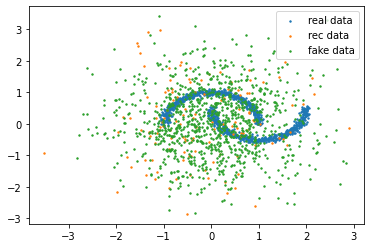

step 1000: KL: 1.622e+00, rec: 6.080e+00


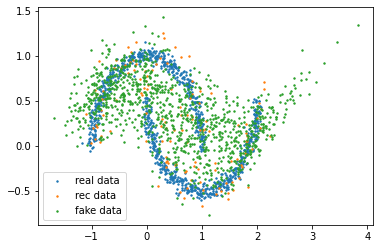

step 2000: KL: 1.830e+00, rec: 5.225e+00


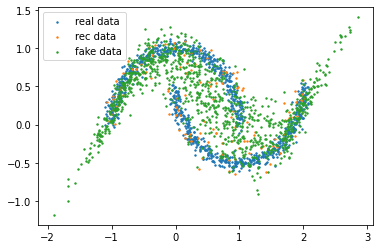

step 3000: KL: 1.918e+00, rec: 4.783e+00


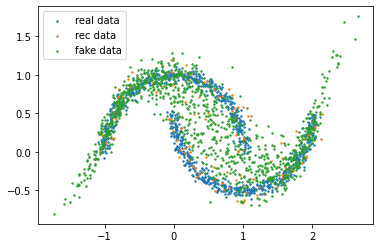

step 4000: KL: 1.948e+00, rec: 5.131e+00


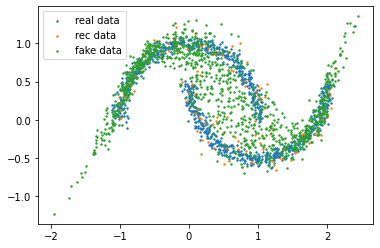

step 5000: KL: 1.924e+00, rec: 4.739e+00


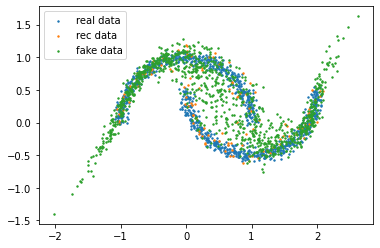

step 6000: KL: 2.022e+00, rec: 4.664e+00


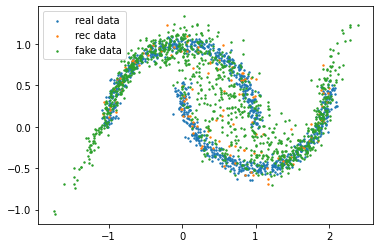

step 7000: KL: 2.081e+00, rec: 5.173e+00


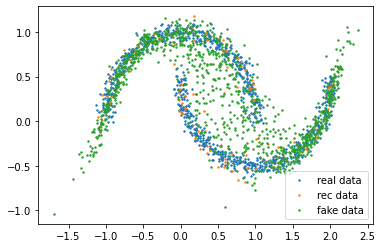

step 8000: KL: 2.049e+00, rec: 4.745e+00


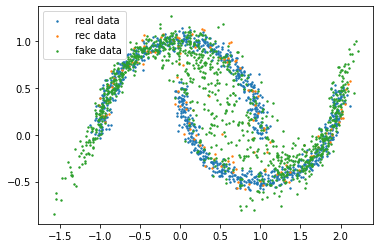

step 9000: KL: 2.090e+00, rec: 4.306e+00


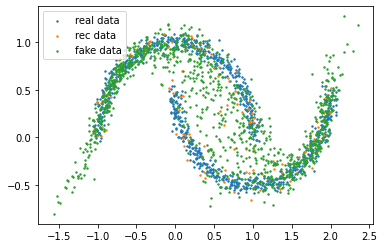

step 10000: KL: 2.069e+00, rec: 4.311e+00


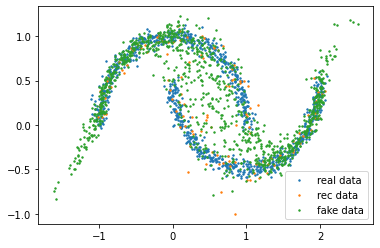

step 11000: KL: 2.111e+00, rec: 4.138e+00


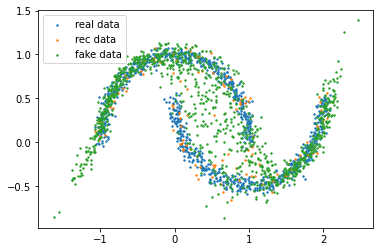

step 12000: KL: 2.115e+00, rec: 4.509e+00


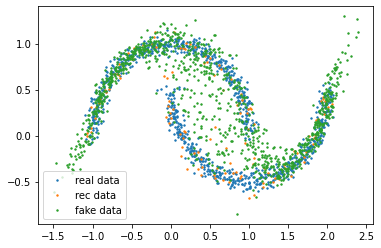

step 13000: KL: 2.154e+00, rec: 4.090e+00


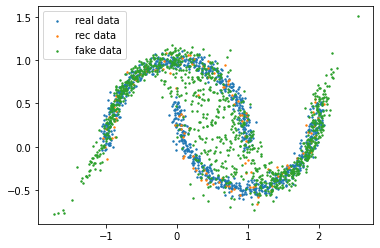

step 14000: KL: 2.171e+00, rec: 4.141e+00


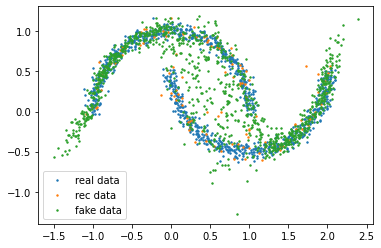

step 15000: KL: 2.179e+00, rec: 3.993e+00


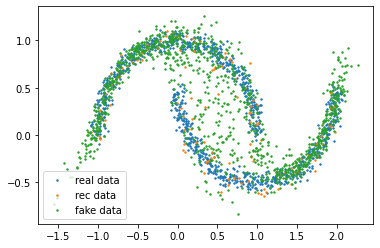

step 16000: KL: 2.239e+00, rec: 3.802e+00


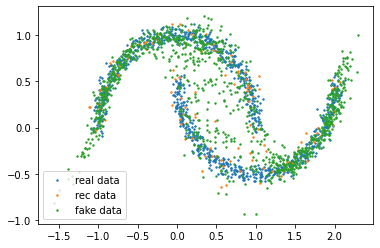

step 17000: KL: 2.191e+00, rec: 3.736e+00


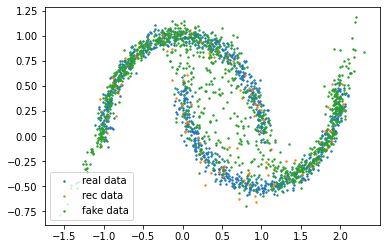

step 18000: KL: 2.217e+00, rec: 4.066e+00


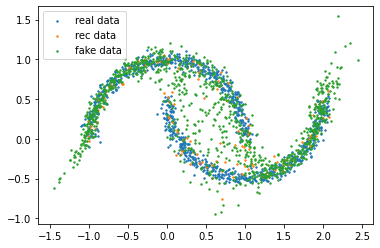

step 19000: KL: 2.223e+00, rec: 3.865e+00


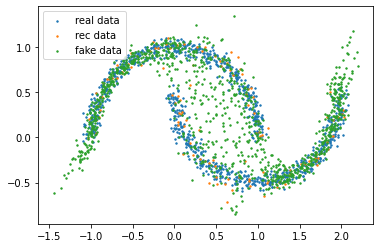

step 20000: KL: 2.237e+00, rec: 3.949e+00


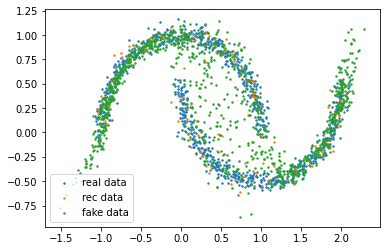

step 21000: KL: 2.251e+00, rec: 4.145e+00


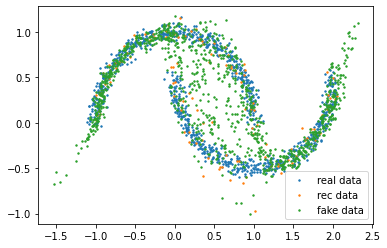

step 22000: KL: 2.317e+00, rec: 6.767e+00


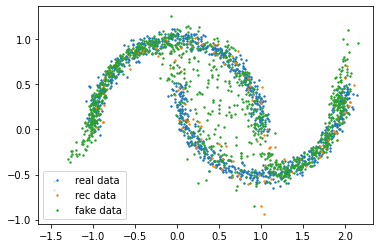

step 23000: KL: 2.259e+00, rec: 3.896e+00


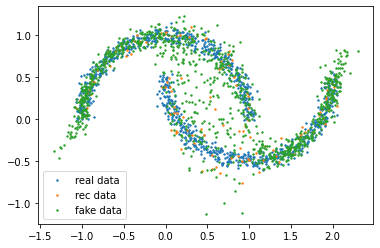

step 24000: KL: 2.280e+00, rec: 4.230e+00


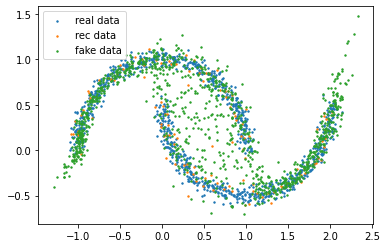

step 25000: KL: 2.293e+00, rec: 3.753e+00


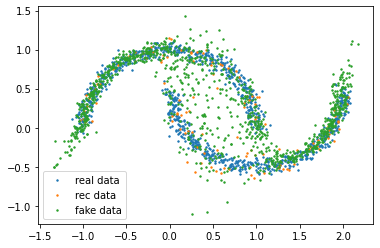

step 26000: KL: 2.284e+00, rec: 3.636e+00


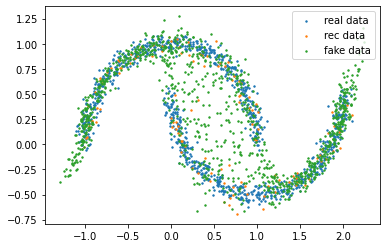

step 27000: KL: 2.305e+00, rec: 4.428e+00


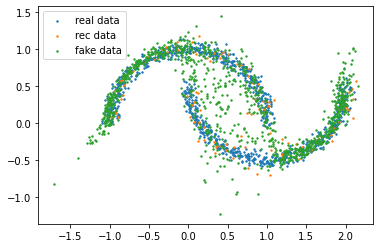

step 28000: KL: 2.314e+00, rec: 3.837e+00


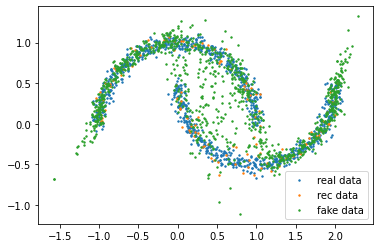

step 29000: KL: 2.320e+00, rec: 3.465e+00


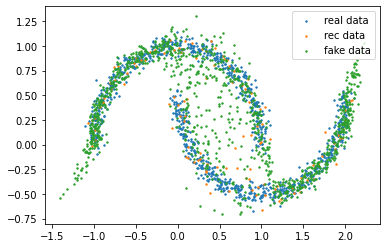

step 30000: KL: 2.306e+00, rec: 3.522e+00


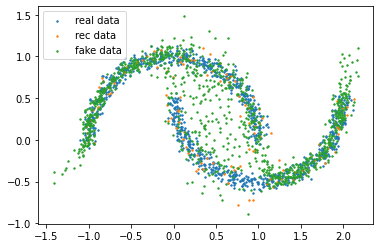

step 31000: KL: 2.316e+00, rec: 3.601e+00


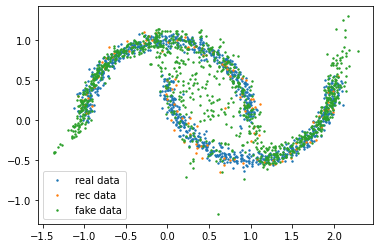

step 32000: KL: 2.346e+00, rec: 3.547e+00


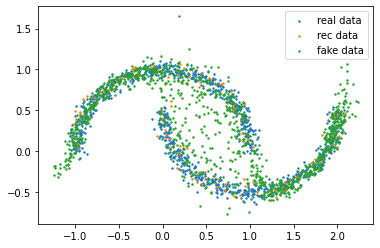

step 33000: KL: 2.335e+00, rec: 3.920e+00


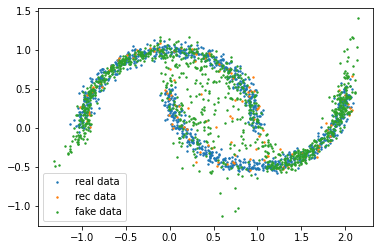

step 34000: KL: 2.361e+00, rec: 3.433e+00


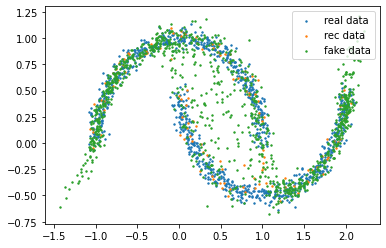

step 35000: KL: 2.332e+00, rec: 3.497e+00


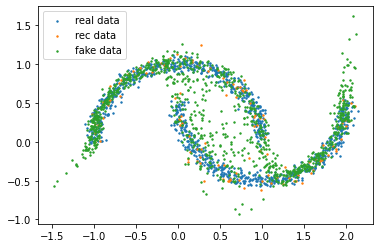

step 36000: KL: 2.319e+00, rec: 3.751e+00


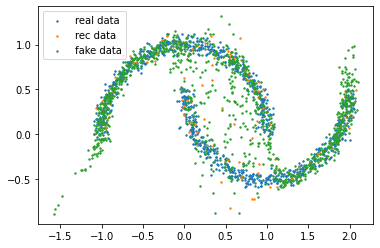

step 37000: KL: 2.363e+00, rec: 3.586e+00


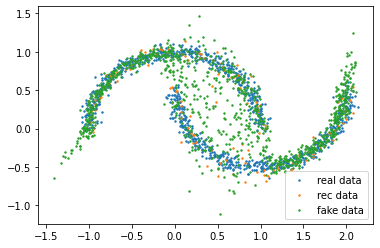

step 38000: KL: 2.387e+00, rec: 3.569e+00


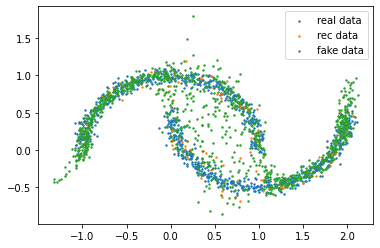

step 39000: KL: 2.382e+00, rec: 3.526e+00


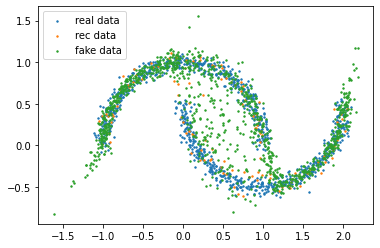

In [13]:
experiment_param = {
    "batch_len": 128,
    "n_hidden_layers": 1,
    "n_neurons": 128,
    "latent_n": 10,
    "variance_enforcing": False,
}
_ = run_vae_experiment(experiment_param, benchmark=False)

**Q12: Try hardcoding $\sigma_\theta(z)$ to some small value (like 1E-4) rather than allowing the decoder to learn it. What does it change?**

step 0: KL: 9.214e-02, rec: 6.941e+07


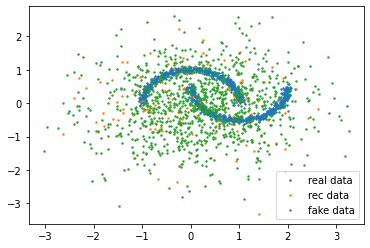

step 1000: KL: 3.671e+01, rec: 3.469e+03


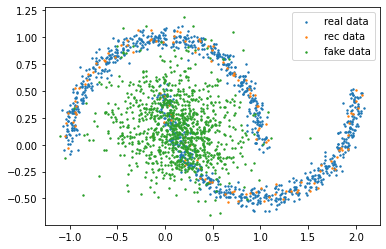

step 2000: KL: 3.908e+01, rec: 3.736e+03


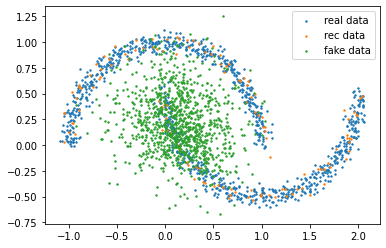

step 3000: KL: 4.316e+01, rec: 4.901e+04


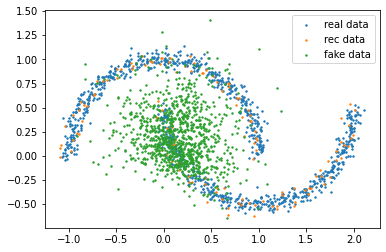

step 4000: KL: 4.579e+01, rec: 5.373e+04


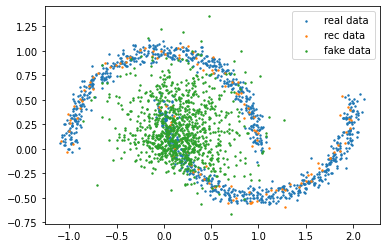

step 5000: KL: 4.500e+01, rec: 1.830e+04


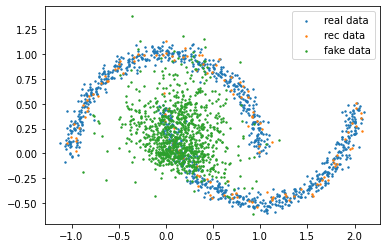

step 6000: KL: 4.521e+01, rec: 1.282e+04


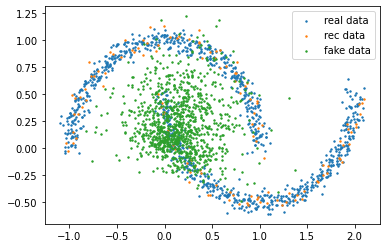

step 7000: KL: 4.309e+01, rec: 4.473e+04


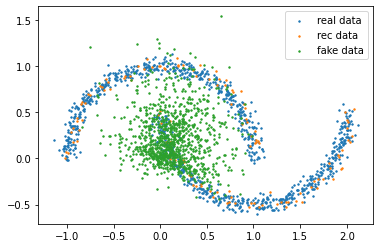

step 8000: KL: 4.103e+01, rec: 5.010e+04


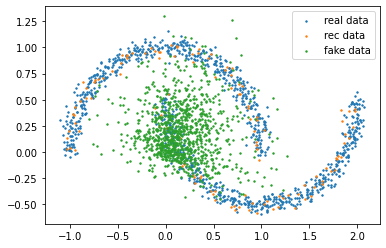

step 9000: KL: 4.000e+01, rec: 1.467e+04


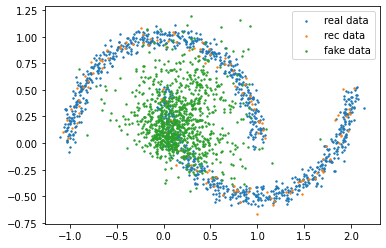

step 10000: KL: 3.928e+01, rec: 4.777e+03


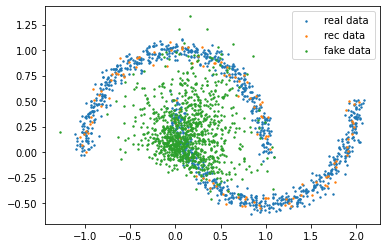

step 11000: KL: 3.891e+01, rec: 4.942e+03


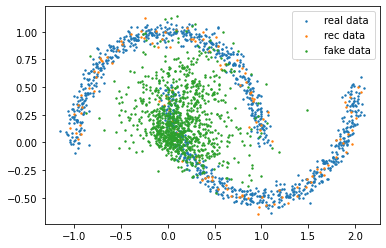

step 12000: KL: 3.825e+01, rec: 1.030e+03


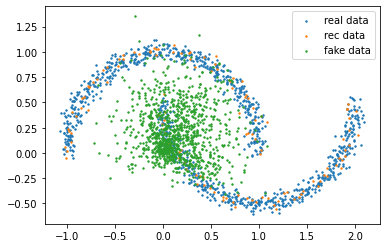

step 13000: KL: 3.860e+01, rec: 3.640e+04


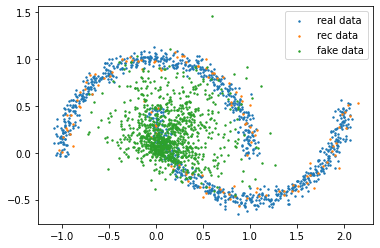

step 14000: KL: 3.691e+01, rec: 3.698e+04


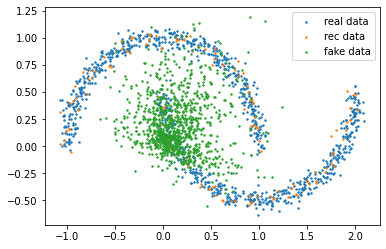

step 15000: KL: 3.761e+01, rec: 1.403e+04


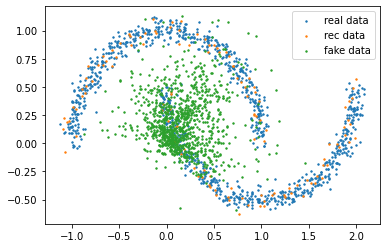

step 16000: KL: 3.717e+01, rec: 8.907e+04


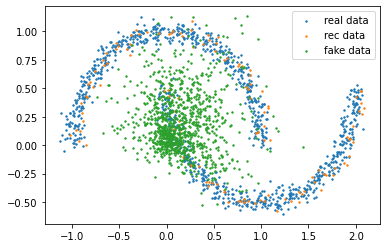

step 17000: KL: 3.706e+01, rec: 7.669e+03


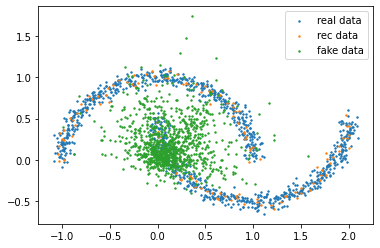

step 18000: KL: 3.782e+01, rec: 8.946e+03


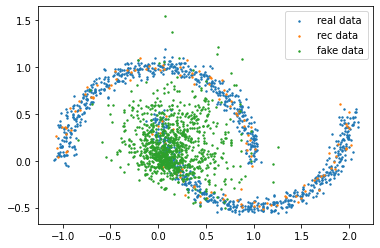

step 19000: KL: 3.738e+01, rec: 5.063e+03


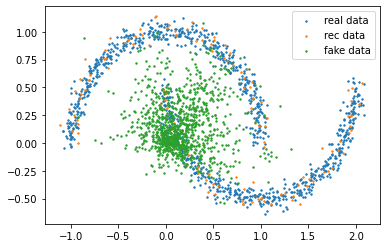

step 20000: KL: 3.747e+01, rec: 2.068e+04


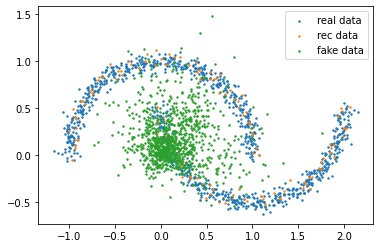

step 21000: KL: 3.758e+01, rec: 5.737e+02


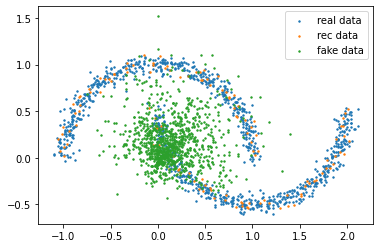

step 22000: KL: 3.763e+01, rec: 8.816e+02


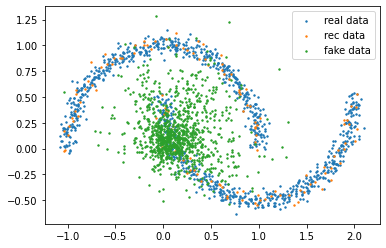

step 23000: KL: 3.729e+01, rec: 6.148e+02


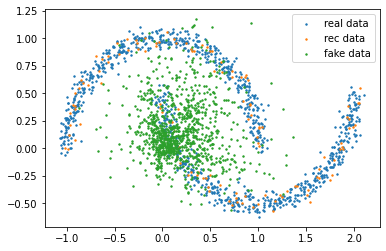

step 24000: KL: 3.712e+01, rec: 4.031e+03


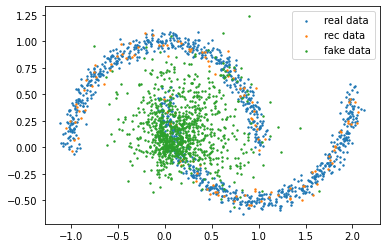

step 25000: KL: 3.675e+01, rec: 9.532e+03


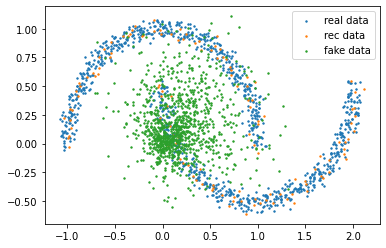

step 26000: KL: 3.663e+01, rec: 2.206e+04


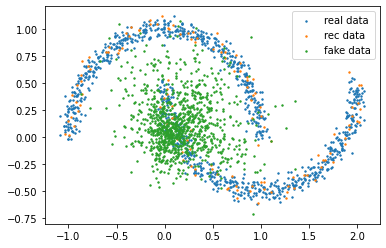

step 27000: KL: 3.654e+01, rec: 2.697e+04


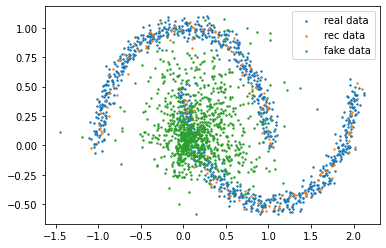

step 28000: KL: 3.781e+01, rec: 9.500e+02


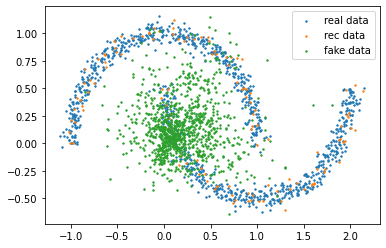

step 29000: KL: 3.716e+01, rec: 5.410e+03


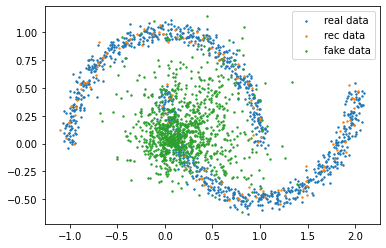

step 30000: KL: 3.718e+01, rec: 5.358e+03


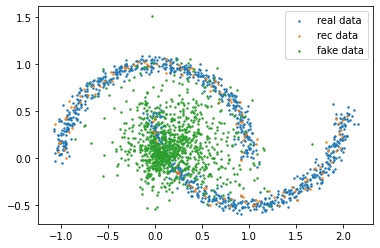

step 31000: KL: 3.731e+01, rec: 4.056e+04


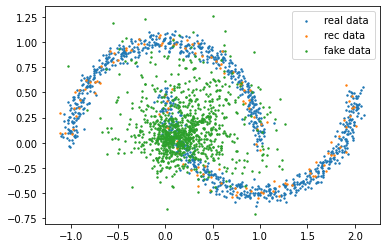

step 32000: KL: 3.742e+01, rec: 2.325e+03


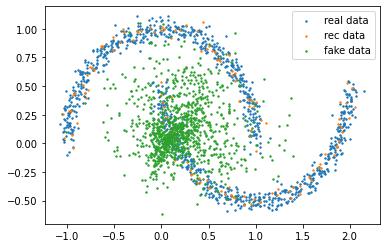

step 33000: KL: 3.711e+01, rec: 2.290e+04


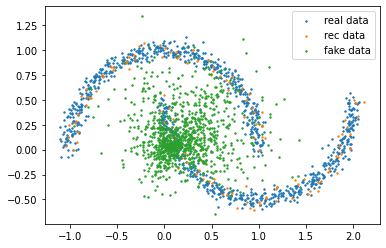

step 34000: KL: 3.659e+01, rec: 4.555e+03


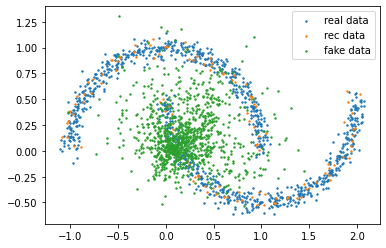

step 35000: KL: 3.709e+01, rec: 4.245e+03


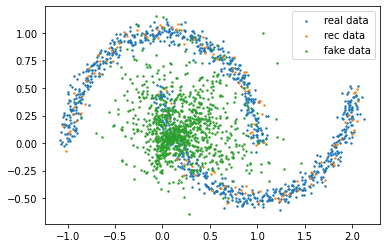

step 36000: KL: 3.606e+01, rec: 6.989e+03


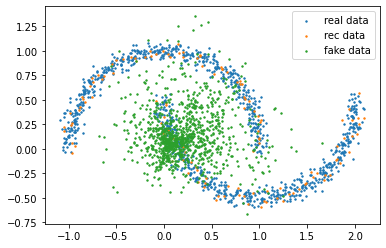

step 37000: KL: 3.664e+01, rec: 3.776e+04


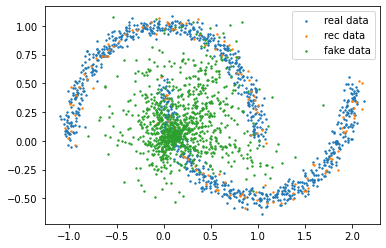

step 38000: KL: 3.615e+01, rec: 2.819e+03


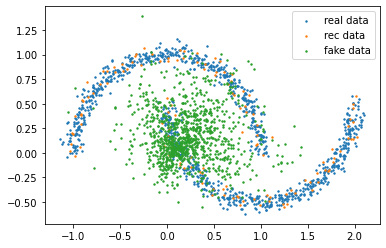

step 39000: KL: 3.630e+01, rec: 2.382e+03


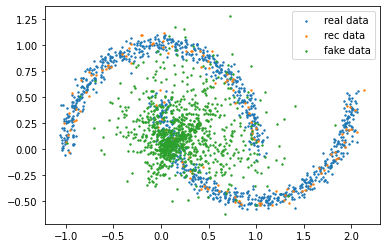

In [14]:
experiment_param = {
    "batch_len": 128,
    "n_hidden_layers": 1,
    "n_neurons": 128,
    "latent_n": 10,
    "variance_enforcing": True,
}
_ = run_vae_experiment(experiment_param, benchmark=False)

> By hardcoding $\sigma_\theta(z)$, we only let the VAE learn the mean of the distribution $\mu_\theta(z)$, thus leading to an optimization problem which is much easier to solve. Therefore, we see that the model converges quickly to a solution where fake data that are generated are distributed around the "mean" of the distribution, i.e roughly at the barycenter of the two moons datasets. This faster optimization process has the drawback of not being able to properly learn the correct data distribution as the very small value of $\sigma_\theta(z)$ reduced the expressivity of the model, preventing from generating point that are far from the mean $\mu_\theta(z)$.

**Q13: How do the power of encoder and decoder affect the overall training of the VAE?**

In [15]:
N_ITER = 4000

experiment_param = {
    "batch_len": 128,
    "n_hidden_layers": 1,
    "n_neurons": 128,
    "latent_n": 10,
    "variance_enforcing": False,
}

results_width = {}
results_depth = {}
results_latent_n = {}

# Experiment for latent dimension
for latent_n in [10, 50, 100]:
    experiment_param["latent_n"] = latent_n
    losses = run_vae_experiment(experiment_param, benchmark=True)
    results_latent_n[latent_n] = losses

experiment_param["latent_n"] = 10

# Experiment for depth
for n_hidden_layers in [1, 2, 3]:
    experiment_param["n_hidden_layers"] = n_hidden_layers
    losses = run_vae_experiment(experiment_param, benchmark=True)
    results_depth[n_hidden_layers] = losses

experiment_param["n_hidden_layers"] = 1


# Experiment for width
for n_neurons in [64, 128, 256]:
    experiment_param["n_neurons"] = n_neurons
    losses = run_vae_experiment(experiment_param, benchmark=True)
    results_width[n_neurons] = losses

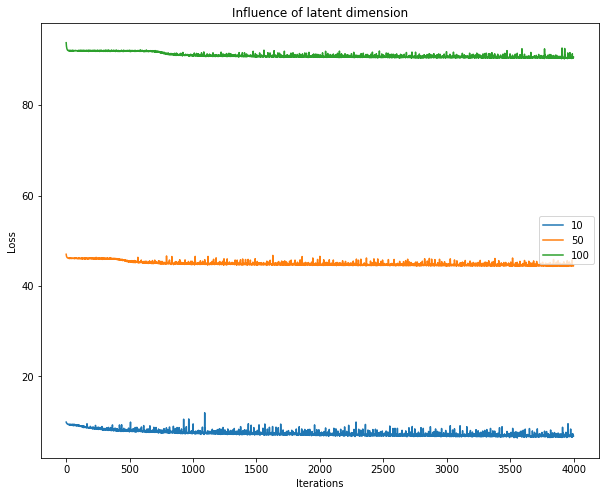

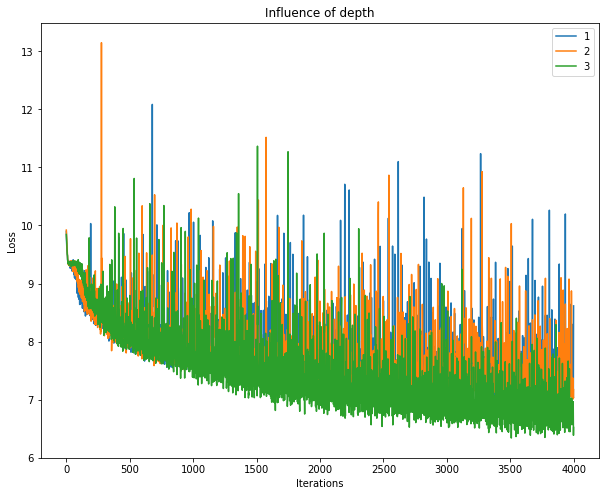

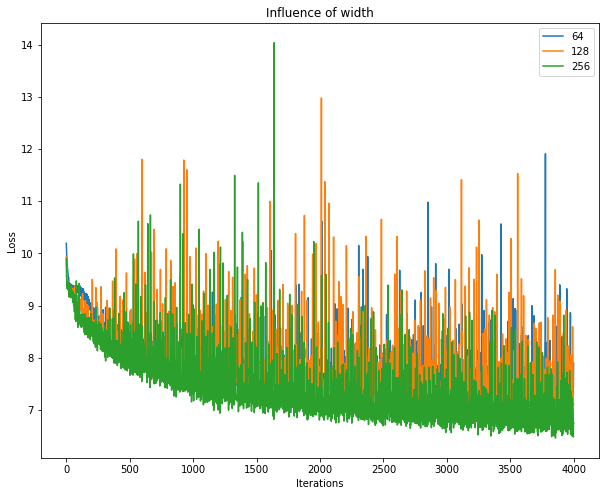

In [16]:
fig_size = (10, 8)
plt.figure(figsize=fig_size)

for latent_n, losses in results_latent_n.items():
    plt.plot(losses, label=latent_n)
plt.title("Influence of latent dimension")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

plt.figure(figsize=fig_size)

for depth, losses in results_depth.items():
    plt.plot(losses, label=depth)
plt.title("Influence of depth")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

plt.figure(figsize=fig_size)

for width, losses in results_width.items():
    plt.plot(losses, label=width)
plt.title("Influence of width")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

> - First, looking at the **latent dimension** (which is not really related to the encoder / decoder power but was still interesting to look at), one can see that the higher the latent dimension, the higher the loss for a fixed number of iterations, even if we "know" that having a higher latent dimension can still be an advantage as it increases the model expressivity (but may require a longer training).
>
> - Samely, increasing the **depth** of the encoder / decoder tends to lead to a higher loss for a given number of iterations, but at the same time, it smoothes the training (less oscillations).
>
> - Concerning the **width**, increasing its value provides a model that converges to lower losses, meaning that the model has gained in expressivity, but the training looks less stable. A possible hypothesis of this instability could come from the decoder, as increasing its expressivity too much may allow it to decode "noise" and thus produce noisy generated data points.

### Normalizing flows

Another approach to generative modelling is given by Normalizing flows. The idea is to learn a mapping $f$ from the data distribution $p_D$ (defined over a space $\mathcal{X}$) to a known distribution (typically, a normal distribution) from which we know how to sample. Two key points are to be noted:
1. The mapping needs to be bijective (i.e., the network needs to be invertible).
2. The exact likelihood of a data point should be easily computable.

To tackle point 2, let us introduce some notations.
Let us denote by $p_\mathcal{N} = \mathcal{N}(0,1)$ the normal distribution from which we sample $z$. We obtain points $x$ by computing $x = f^{-1}(z)$, and we hope that the distribution of points obtained this way will match more or less the dataset distribution $p_D$ of real examples.
We denote by $p_G$ this obtained distribution, that is, the image of $p_\mathcal{N}$ through $f^{-1}$: $p_G$ is a probability distribution defined on $\mathcal{X}$, and our goal will be to optimize the mapping $f$ so that $p_G$ is close to $p_D$. If you are not familiar with images of distributions, the definition is here: https://en.wikipedia.org/wiki/Pushforward_measure ; it can be defined as the measure that satisfies this change of variables: $\int_{z\sim p_\mathcal{N}} g(f^{-1}(z)) dz = \int_{x\sim p_{G}} g(x) dx$ for all functions $g$. Another notation for this is $\int_{z} g(f^{-1}(z)) \;dp_\mathcal{N}(z) = \int_{x} g(x) \;dp_{G}(x)$. 
We will build on the following identity:
$$
\log(p_X(x))=\log(p_Z(z))+\log \det J_f
$$
where $J_f = \frac{df(x)}{dx}$ is the Jacobian matrix of the function $f$.

**Q14: Justify the above equality**

> We have $z = f(x)$ and thus $x = f^{-1}(z)$. Therefore, the change of variable formula for distribution yields: 
$p_Z(z) = p_X(x) det\left(\frac{\partial f(x)}{\partial x}\right)^{-1} = p_X(x) det(J_{f})^{-1}$.
>
>Therefore: $log(p_Z(z)) = log(p_X(x)) - log(det(J_{f}))$. Hence the identity:
>
>$log(p_X(x))=log(p_Z(z))+log(det(J_f))$.

Let us consider, as an optimization criterion, the Kullback-Leibler divergence $KL(p_D||p_G)$.

**Q15: Express this loss as a (very simple) function of the quantity above.**

> We have: $KL(p_D||p_G) = \mathbb{E}_{p_D}\left[log(\frac{p_D}{p_G})\right] = \mathbb{E}_{p_D}\left[log(p_D) - log(p_G)\right] = \mathbb{E}_{p_D}\left[log(det(J_f))\right]$ by previous question's result.
>
> Therefore: $KL(p_D||p_G) = log(det(J_f))$.

A challenging task is then to find a network, such that f is:
* invertible
* $\det J_f$ is tractable
* $f$ is general enough

A common architecture is the so called real-valued non-volume preserving (real-NVP), which is made of coupling layers.

The idea of coupling layers is to cut the input $x$ in two (let say keeping only the $d < D$ first dimensions on one hand and the $D-d$ other dimensions on the other hand, with $D$ the dimension of the input space $\mathcal{X}$). This gives inputs $x_{1:d}$ and $x_{d+1:D}$. Then the forward pass is defined as:
* $y_{1:d}=x_{1:d}$
* $y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})$

where $s,t:\mathbb{R}^d\to\mathbb{R}^{D-d}$ and $\odot$ is the coefficient-wise multiplication of two vectors of the same size.

Those equations can be resumed in the following diagram:
![real NVP diagram](realNVPforward.png)

**Q16: Show that the defined mapping is indeed invertible**

> Let's define the following mapping: $g: y \rightarrow x = g(y)$, such that:
>
>$x_{1:d}=y_{1:d}$
>
>$x_{d+1:D}=(y_{d+1:D} - t(y_{1:d}))\odot \exp(-s(y_{1:d}))$
>
> We have $f(g(x)) = g(f(x))$ with $f: x \rightarrow y = f(x)$ defined by:
>
> $y_{1:d}=x_{1:d}$
>
> $y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})$
> 
> which means that g is the reciprocal of the mapping f, so the defined mapping is indeed **invertible**.


**Q17: Show that the determinant of the Jacobian of such a mapping is $\exp(\sum_j s(x_{1:d})_j)$**

> Let's show that $J_f$ is a triangular matrix, which will help computing its determinant. First, we can dvide $J_f$ in 4 blocks: 
$$\begin{pmatrix} A & B \\ C & D \end{pmatrix}$$
with $A = (\frac{\partial y_i}{\partial x_j})_{1 \leq i,j \leq d} = (1_{i = j})_{1 \leq i,j \leq d} = I_d$, with $I_d$ being the identity matrix of size $d$.
>
>$B = (\frac{\partial y_i}{\partial x_j})_{1 \leq i \leq d, d + 1 \leq j \leq D} = 0_{d, D - d}$
>
>$C = (\frac{\partial y_i}{\partial x_j})_{d + 1 \leq i \leq D, 1 \leq j \leq d}$. However, as $B = 0_{d, D - d}$, we don't need to detail this part of the Jacobian as it won't play any role in the computation of the determinant (as we already have a block triangular matrix).
>
>$D = (\frac{\partial y_i}{\partial x_j})_{d + 1 \leq i \leq D, d + 1 \leq j \leq D} = (1_{i = j} exp(s(x_{1:d})))_{d + 1 \leq i \leq D, d + 1 \leq j \leq D} = Diag(exp(s(x_{1:d})))$
>
> Therefore $det(J_f) = det(D) = \prod_{j} exp(s(x_{1:d})_j) = exp(\sum_{j}s(x_{1:d})_j)$

**Q18: Fill the Coupling layer structure below by defining suitable functions sfun and tfun (using a final tanh in sfun is highly recommended) and the inverse pass**

In [17]:
import torch
from torch import nn
from torch.nn import functional as F


class Encoder(nn.Module):
    def __init__(self, n_hidden_layers, n_neurons, latent_n):
        super().__init__()    
        self.latent_n = latent_n
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(2, n_neurons))
        for _ in range(n_hidden_layers):
            self.layers.append(nn.Linear(n_neurons, n_neurons)) 
        self.layers.append(nn.Linear(n_neurons, 2 * latent_n))
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        for i in range(len(self.layers) - 1):
            x = self.layers[i](x)
            x = activation(x)
    
        x = self.layers[-1](x)
        mu, logvar = torch.split(
            x,
            split_size_or_sections=self.latent_n,
            dim=1,
        )
        return (mu, logvar)
    


class CouplingLayer(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask):
        super().__init__()
        ### define here variables to use in t and s ###
        self.s_layers = nn.ModuleList()
        self.s_layers.append(nn.Linear(input_size, hidden_size))
        self.s_layers.append(nn.Linear(hidden_size, hidden_size))
        self.s_layers.append(nn.Linear(hidden_size, output_size))
        
        self.t_layers = nn.ModuleList()
        self.t_layers.append(nn.Linear(input_size, hidden_size))
        self.t_layers.append(nn.Linear(hidden_size, hidden_size))
        self.t_layers.append(nn.Linear(hidden_size, output_size))
        ###
        self.mask = mask #we use the mask variable to make the cut in input

    def sfun(self, x_m):
        for i in range(len(self.s_layers) - 1):
            x_m = self.s_layers[i](x_m)
            x_m = nn.ReLU()(x_m)
        x_m = self.s_layers[-1](x_m)
        return nn.Tanh()(x_m)
        
    def tfun(self, x_m):
        for i in range(len(self.t_layers) - 1):
            x_m = self.t_layers[i](x_m)
            x_m = nn.ReLU()(x_m)
        return self.t_layers[-1](x_m)
        
    def forward(self, x):
        x_m = x * self.mask
        s_out = self.sfun(x_m) # multiplicative block
        t_out = self.tfun(x_m) # additive block
        y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
        log_det_jacobian = s_out.sum(dim=1)  # CRITICAL
        return y, log_det_jacobian

    def inverse(self, y):
        y_m = y * self.mask
        s_out = self.sfun(y_m) * (1 - self.mask)
        t_out = self.tfun(y_m) * (1 - self.mask)
        x = y_m + (1 - self.mask) * (y - t_out) * torch.exp(-s_out)
        return x

In [18]:
class RealNVP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask, n_layers=6):
        super().__init__()
        assert n_layers >= 2, "num of coupling layers should be greater or equal to 2"

        self.modules = []
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        for _ in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, 1 - mask))
        self.module_list = nn.ModuleList(self.modules)

    def forward(self, x):
        ldj_sum = 0  # sum of log determinant of jacobian
        for module in self.module_list:
            x, ldj = module(x)
            ldj_sum += ldj
        return x, ldj_sum

    def inverse(self, z):
        for module in reversed(self.module_list):
            z = module.inverse(z)
        return z

In [19]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch


def train(epoch, model, optimizer, prior_z, train_loader, log_interval=50):
    model.train()
    train_loss = 0
    for batch_idx, x_inputs in enumerate(train_loader):
        optimizer.zero_grad()
        z_outputs, log_det_j_sum = model.forward(x_inputs)  # train with the forward
        loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean()  # CRITICAL
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(x_inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), cur_loss / len(x_inputs)))

    average_train_loss = train_loss / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average train loss: {average_train_loss:.4f}")


def test(epoch, model, prior_z, test_loader, plot_args):
    model.eval()
    test_loss = 0
    x_all = np.array([[]]).reshape(0, 2)
    z_all = np.array([[]]).reshape(0, 2)
    with torch.no_grad():
        for batch_idx, x_inputs in enumerate(test_loader):
            z_outputs, log_det_j_sum = model.forward(x_inputs)
            cur_loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean().item()
            test_loss += cur_loss
            x_all = np.concatenate((x_all, x_inputs.numpy()))
            z_all = np.concatenate((z_all, z_outputs.numpy()))
        
        subfig_plot(1, x_all, *plot_args, "Input: x ~ p(x)", "b")
        subfig_plot(2, z_all, *plot_args, "Output: z = f(x)", "b")

        test_loss /= len(test_loader.dataset)
        print(f"====> Test loss: {test_loss:.4f}")


def sample(epoch, model, prior_z, plot_args, save_plt_interval=5):
    model.eval()
    with torch.no_grad():
        z_inputs = prior_z.sample((1000,))
        x_outputs = model.inverse(z_inputs)  # generation with the inverse
        z_inputs = z_inputs.numpy()
        x_outputs = x_outputs.numpy()
        
        subfig_plot(3, z_inputs, *plot_args, "Input: z ~ p(z)", "r")
        subfig_plot(4, x_outputs, *plot_args, "Output: x = g(z) (g: inverse of f)", "r")

        if epoch % save_plt_interval == 0:
            if not os.path.exists("results"):
                os.makedirs("results")
            plt.savefig("results/"+"result_"+str(epoch)+".png")


def subfig_plot(location, data, x_start, x_end, y_start, y_end, title, color):
    if location == 1:
        plt.clf()
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 2, location)
    plt.scatter(data[:, 0], data[:, 1], c=color, s=1)
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)
    plt.title(title)
    plt.pause(1e-2)

In [20]:
# globals
BATCH_SIZE = 128
LOG_INTERVAL = 50
N_EPOCHS = 10
INPUT_SIZE = 2
OUTPUT_SIZE = 2
HIDDEN_SIZE = 256
SAVE_PLT_INTERVAL = 5
N_COUPLING_LAYERS = 8

In [21]:
# data loading
train_data = datasets.make_moons(n_samples=50000, noise=.05)[0].astype(np.float32)
test_data = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)

In [22]:
from torch import distributions # optim, 
# model construction
mask = torch.from_numpy(np.array([0, 1]).astype(np.float32))
model = RealNVP(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, mask, N_COUPLING_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
prior_z = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.022789
Train Epoch: 1 [6400/50000 (13%)]	Loss: -0.036787
Train Epoch: 1 [12800/50000 (26%)]	Loss: -0.049827
Train Epoch: 1 [19200/50000 (38%)]	Loss: -0.053894
Train Epoch: 1 [25600/50000 (51%)]	Loss: -0.053563
Train Epoch: 1 [32000/50000 (64%)]	Loss: -0.055303
Train Epoch: 1 [38400/50000 (77%)]	Loss: -0.055579
Train Epoch: 1 [44800/50000 (90%)]	Loss: -0.055920
====> Epoch: 1 Average train loss: -0.0483


<Figure size 432x288 with 0 Axes>

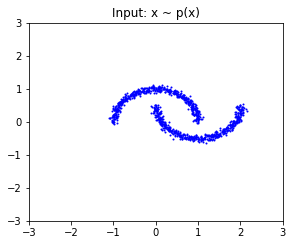

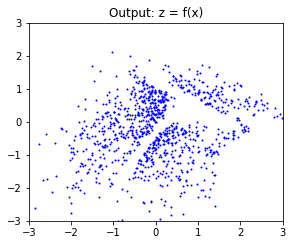

====> Test loss: -0.0577


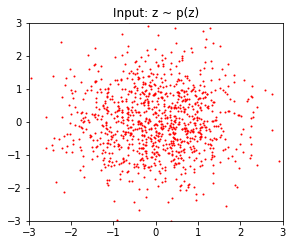

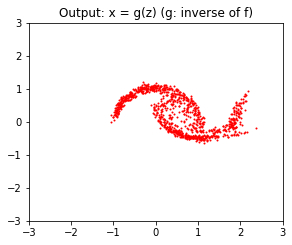

Train Epoch: 2 [0/50000 (0%)]	Loss: -0.055829
Train Epoch: 2 [6400/50000 (13%)]	Loss: -0.057038
Train Epoch: 2 [12800/50000 (26%)]	Loss: -0.056591
Train Epoch: 2 [19200/50000 (38%)]	Loss: -0.057924
Train Epoch: 2 [25600/50000 (51%)]	Loss: -0.057474
Train Epoch: 2 [32000/50000 (64%)]	Loss: -0.058219
Train Epoch: 2 [38400/50000 (77%)]	Loss: -0.057694
Train Epoch: 2 [44800/50000 (90%)]	Loss: -0.057320
====> Epoch: 2 Average train loss: -0.0576


<Figure size 432x288 with 0 Axes>

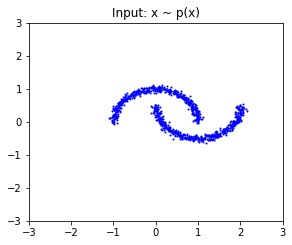

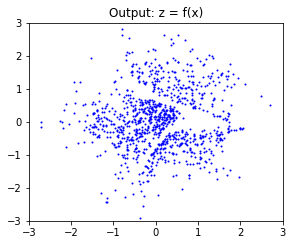

====> Test loss: -0.0590


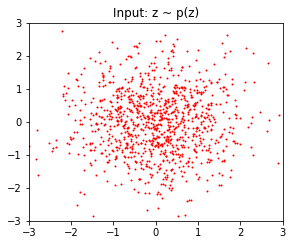

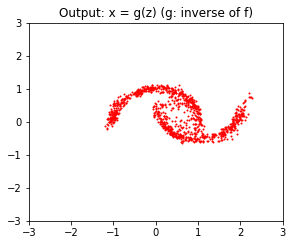

Train Epoch: 3 [0/50000 (0%)]	Loss: -0.058372
Train Epoch: 3 [6400/50000 (13%)]	Loss: -0.057215
Train Epoch: 3 [12800/50000 (26%)]	Loss: -0.058819
Train Epoch: 3 [19200/50000 (38%)]	Loss: -0.058751
Train Epoch: 3 [25600/50000 (51%)]	Loss: -0.057728
Train Epoch: 3 [32000/50000 (64%)]	Loss: -0.056994
Train Epoch: 3 [38400/50000 (77%)]	Loss: -0.059314
Train Epoch: 3 [44800/50000 (90%)]	Loss: -0.057313
====> Epoch: 3 Average train loss: -0.0582


<Figure size 432x288 with 0 Axes>

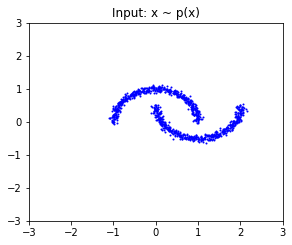

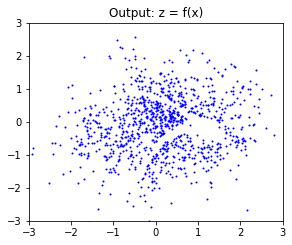

====> Test loss: -0.0597


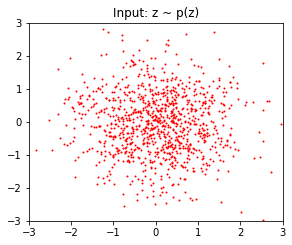

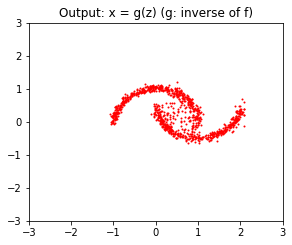

Train Epoch: 4 [0/50000 (0%)]	Loss: -0.057770
Train Epoch: 4 [6400/50000 (13%)]	Loss: -0.056944
Train Epoch: 4 [12800/50000 (26%)]	Loss: -0.058597
Train Epoch: 4 [19200/50000 (38%)]	Loss: -0.057784
Train Epoch: 4 [25600/50000 (51%)]	Loss: -0.057546
Train Epoch: 4 [32000/50000 (64%)]	Loss: -0.058544
Train Epoch: 4 [38400/50000 (77%)]	Loss: -0.057903
Train Epoch: 4 [44800/50000 (90%)]	Loss: -0.059261
====> Epoch: 4 Average train loss: -0.0585


<Figure size 432x288 with 0 Axes>

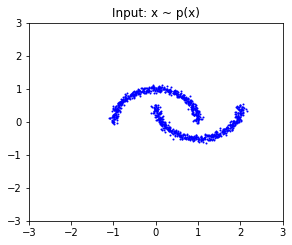

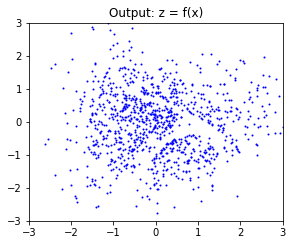

====> Test loss: -0.0599


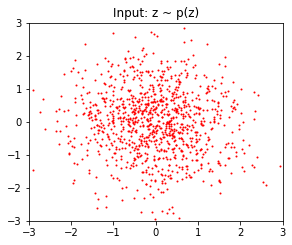

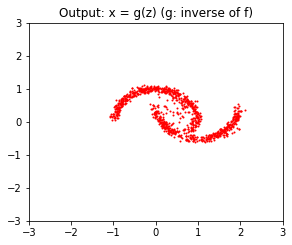

Train Epoch: 5 [0/50000 (0%)]	Loss: -0.058566
Train Epoch: 5 [6400/50000 (13%)]	Loss: -0.058384
Train Epoch: 5 [12800/50000 (26%)]	Loss: -0.058113
Train Epoch: 5 [19200/50000 (38%)]	Loss: -0.059141
Train Epoch: 5 [25600/50000 (51%)]	Loss: -0.059564
Train Epoch: 5 [32000/50000 (64%)]	Loss: -0.058930
Train Epoch: 5 [38400/50000 (77%)]	Loss: -0.059329
Train Epoch: 5 [44800/50000 (90%)]	Loss: -0.059233
====> Epoch: 5 Average train loss: -0.0587


<Figure size 432x288 with 0 Axes>

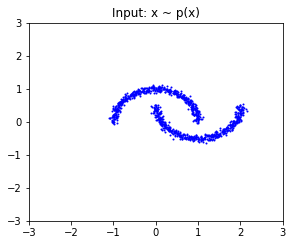

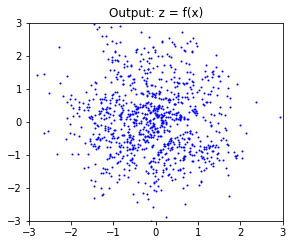

====> Test loss: -0.0596


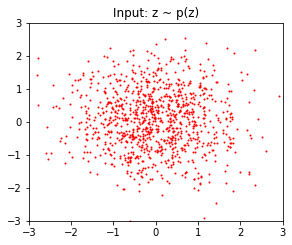

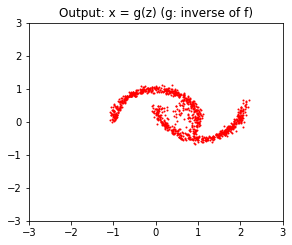

Train Epoch: 6 [0/50000 (0%)]	Loss: -0.058268
Train Epoch: 6 [6400/50000 (13%)]	Loss: -0.058978
Train Epoch: 6 [12800/50000 (26%)]	Loss: -0.058665
Train Epoch: 6 [19200/50000 (38%)]	Loss: -0.059036
Train Epoch: 6 [25600/50000 (51%)]	Loss: -0.058768
Train Epoch: 6 [32000/50000 (64%)]	Loss: -0.058642
Train Epoch: 6 [38400/50000 (77%)]	Loss: -0.058541
Train Epoch: 6 [44800/50000 (90%)]	Loss: -0.058636
====> Epoch: 6 Average train loss: -0.0587


<Figure size 432x288 with 0 Axes>

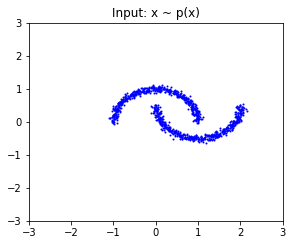

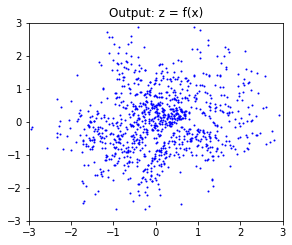

====> Test loss: -0.0598


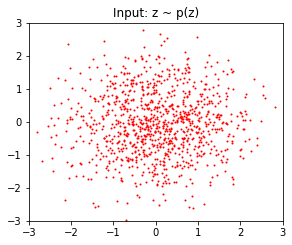

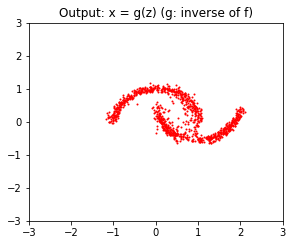

Train Epoch: 7 [0/50000 (0%)]	Loss: -0.058722
Train Epoch: 7 [6400/50000 (13%)]	Loss: -0.058736
Train Epoch: 7 [12800/50000 (26%)]	Loss: -0.059334
Train Epoch: 7 [19200/50000 (38%)]	Loss: -0.058419
Train Epoch: 7 [25600/50000 (51%)]	Loss: -0.059297
Train Epoch: 7 [32000/50000 (64%)]	Loss: -0.059136
Train Epoch: 7 [38400/50000 (77%)]	Loss: -0.059494
Train Epoch: 7 [44800/50000 (90%)]	Loss: -0.058568
====> Epoch: 7 Average train loss: -0.0589


<Figure size 432x288 with 0 Axes>

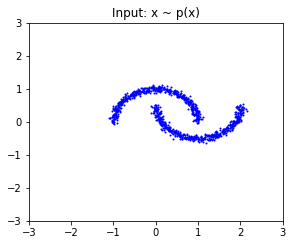

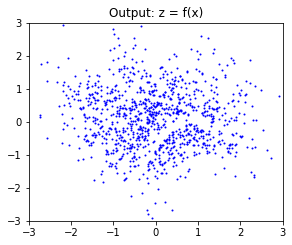

====> Test loss: -0.0602


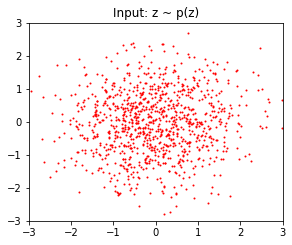

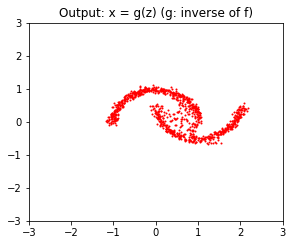

Train Epoch: 8 [0/50000 (0%)]	Loss: -0.058372
Train Epoch: 8 [6400/50000 (13%)]	Loss: -0.058778
Train Epoch: 8 [12800/50000 (26%)]	Loss: -0.058141
Train Epoch: 8 [19200/50000 (38%)]	Loss: -0.058492
Train Epoch: 8 [25600/50000 (51%)]	Loss: -0.059895
Train Epoch: 8 [32000/50000 (64%)]	Loss: -0.059184
Train Epoch: 8 [38400/50000 (77%)]	Loss: -0.058486
Train Epoch: 8 [44800/50000 (90%)]	Loss: -0.058203
====> Epoch: 8 Average train loss: -0.0589


<Figure size 432x288 with 0 Axes>

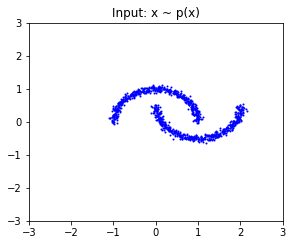

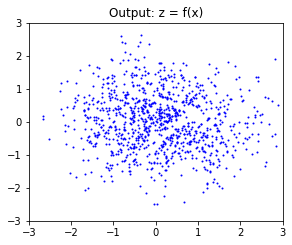

====> Test loss: -0.0603


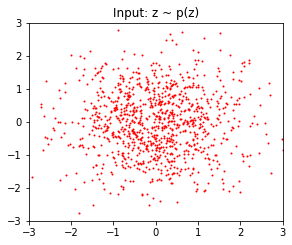

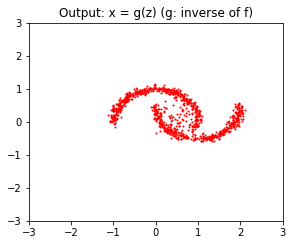

Train Epoch: 9 [0/50000 (0%)]	Loss: -0.059279
Train Epoch: 9 [6400/50000 (13%)]	Loss: -0.059084
Train Epoch: 9 [12800/50000 (26%)]	Loss: -0.059569
Train Epoch: 9 [19200/50000 (38%)]	Loss: -0.057729
Train Epoch: 9 [25600/50000 (51%)]	Loss: -0.059502
Train Epoch: 9 [32000/50000 (64%)]	Loss: -0.059033
Train Epoch: 9 [38400/50000 (77%)]	Loss: -0.059426
Train Epoch: 9 [44800/50000 (90%)]	Loss: -0.059486
====> Epoch: 9 Average train loss: -0.0590


<Figure size 432x288 with 0 Axes>

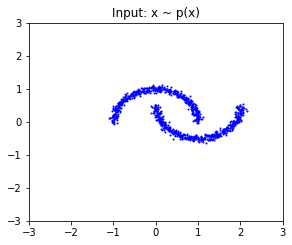

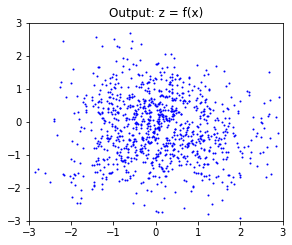

====> Test loss: -0.0601


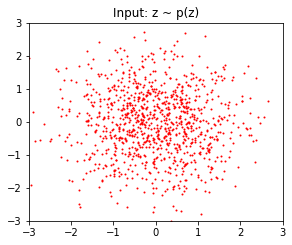

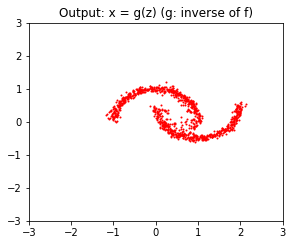

Train Epoch: 10 [0/50000 (0%)]	Loss: -0.059369
Train Epoch: 10 [6400/50000 (13%)]	Loss: -0.058617
Train Epoch: 10 [12800/50000 (26%)]	Loss: -0.058829
Train Epoch: 10 [19200/50000 (38%)]	Loss: -0.059096
Train Epoch: 10 [25600/50000 (51%)]	Loss: -0.059082
Train Epoch: 10 [32000/50000 (64%)]	Loss: -0.059642
Train Epoch: 10 [38400/50000 (77%)]	Loss: -0.059052
Train Epoch: 10 [44800/50000 (90%)]	Loss: -0.057789
====> Epoch: 10 Average train loss: -0.0591


<Figure size 432x288 with 0 Axes>

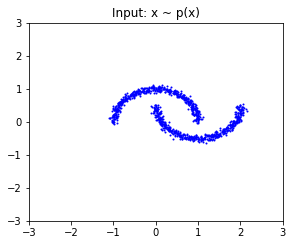

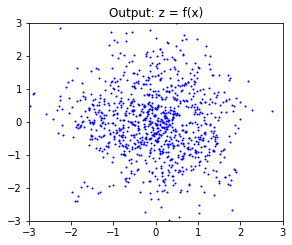

====> Test loss: -0.0602


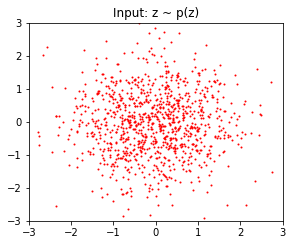

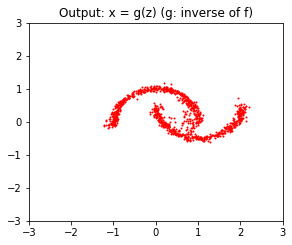

'156.01s'

<Figure size 432x288 with 0 Axes>

In [23]:
from timeit import default_timer as timer
# run
plot_args = (-3, 3, -3, 3)
start = timer()
for epoch in range(1, N_EPOCHS + 1):
    train(epoch, model, optimizer, prior_z, train_loader)
    test(epoch, model, prior_z, test_loader, plot_args)
    sample(epoch, model, prior_z, plot_args)
f"{timer() - start:.02f}s"

**Q19: Explain why Normalizing flows do not fit well when there are many clusters in data**

> As the prior $p_Z$ is a simple normal distribution, we can have the intuition that Normalizing flows may only be able to generate data that correspond to a unique "group" / cluster of data, and that the mapping $f$ will try to capture features / characteristics of the data inside this group. When there are multiple clusters, the latent variable $z$ sampled from $p_Z$, must now, after encoding be able to capture not only the characteristics of the gererated point, but must first be able to determine from which cluster it needs to be mapped, and a simple multivariate normal distribution as prior may not be expressive enough to encode all this information. Maybe models that would take Gaussians Mixtures as prior would better fit when there are manu clusters in data. Below is given an experiment where wa can see that the Normalizing flow model doesn't succeed in generating accurate datapoints when there are many clusters (using sklearn blobs dataset):

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.559936
Train Epoch: 1 [6400/50000 (13%)]	Loss: 0.015707
Train Epoch: 1 [12800/50000 (26%)]	Loss: -0.001845
Train Epoch: 1 [19200/50000 (38%)]	Loss: -0.010139
Train Epoch: 1 [25600/50000 (51%)]	Loss: -0.013908
Train Epoch: 1 [32000/50000 (64%)]	Loss: -0.016490
Train Epoch: 1 [38400/50000 (77%)]	Loss: -0.018145
Train Epoch: 1 [44800/50000 (90%)]	Loss: -0.017576
====> Epoch: 1 Average train loss: -0.0029


<Figure size 432x288 with 0 Axes>

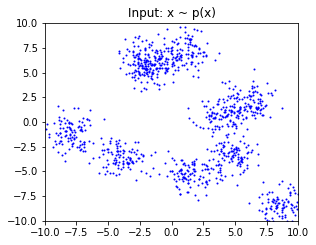

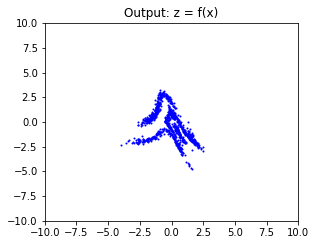

====> Test loss: -0.0105


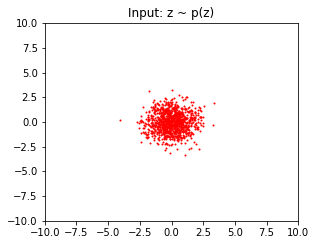

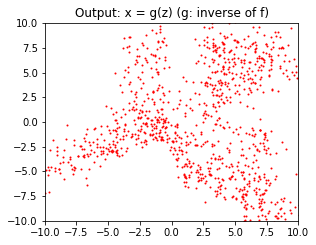

Train Epoch: 2 [0/50000 (0%)]	Loss: -0.018960
Train Epoch: 2 [6400/50000 (13%)]	Loss: -0.019002
Train Epoch: 2 [12800/50000 (26%)]	Loss: -0.018923
Train Epoch: 2 [19200/50000 (38%)]	Loss: -0.019186
Train Epoch: 2 [25600/50000 (51%)]	Loss: -0.019948
Train Epoch: 2 [32000/50000 (64%)]	Loss: -0.021153
Train Epoch: 2 [38400/50000 (77%)]	Loss: -0.020266
Train Epoch: 2 [44800/50000 (90%)]	Loss: -0.020704
====> Epoch: 2 Average train loss: -0.0199


<Figure size 432x288 with 0 Axes>

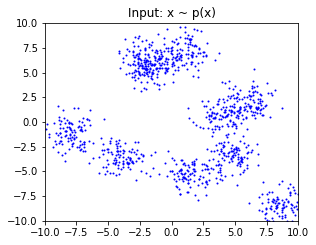

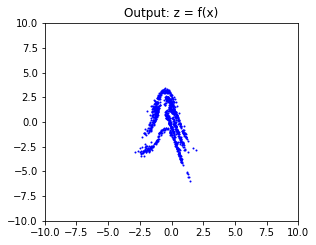

====> Test loss: -0.0082


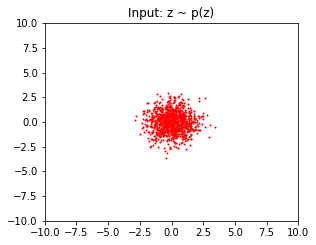

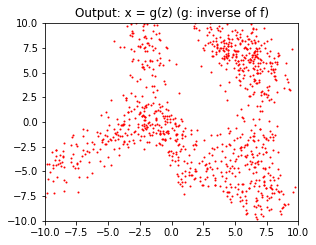

Train Epoch: 3 [0/50000 (0%)]	Loss: -0.020669
Train Epoch: 3 [6400/50000 (13%)]	Loss: -0.022565
Train Epoch: 3 [12800/50000 (26%)]	Loss: -0.020994
Train Epoch: 3 [19200/50000 (38%)]	Loss: -0.021513
Train Epoch: 3 [25600/50000 (51%)]	Loss: -0.021318
Train Epoch: 3 [32000/50000 (64%)]	Loss: -0.021780
Train Epoch: 3 [38400/50000 (77%)]	Loss: -0.021380
Train Epoch: 3 [44800/50000 (90%)]	Loss: -0.021490
====> Epoch: 3 Average train loss: -0.0212


<Figure size 432x288 with 0 Axes>

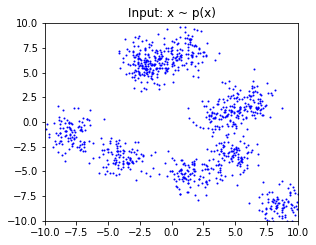

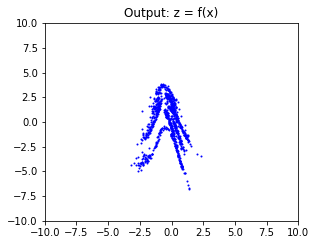

====> Test loss: -0.0047


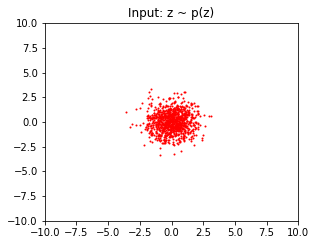

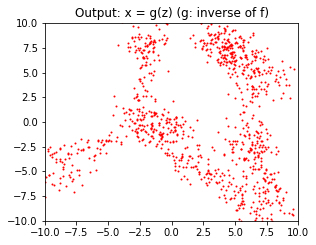

Train Epoch: 4 [0/50000 (0%)]	Loss: -0.021664
Train Epoch: 4 [6400/50000 (13%)]	Loss: -0.022094
Train Epoch: 4 [12800/50000 (26%)]	Loss: -0.021880
Train Epoch: 4 [19200/50000 (38%)]	Loss: -0.021081
Train Epoch: 4 [25600/50000 (51%)]	Loss: -0.021716
Train Epoch: 4 [32000/50000 (64%)]	Loss: -0.022121
Train Epoch: 4 [38400/50000 (77%)]	Loss: -0.021873
Train Epoch: 4 [44800/50000 (90%)]	Loss: -0.022623
====> Epoch: 4 Average train loss: -0.0217


<Figure size 432x288 with 0 Axes>

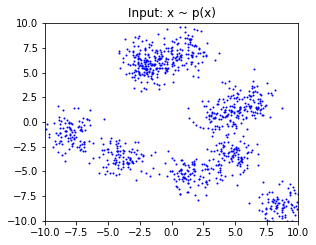

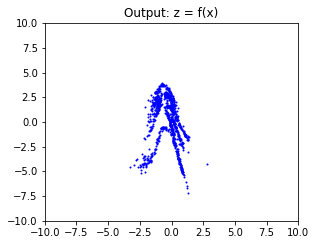

====> Test loss: -0.0018


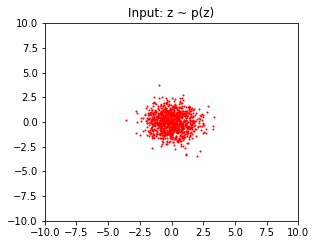

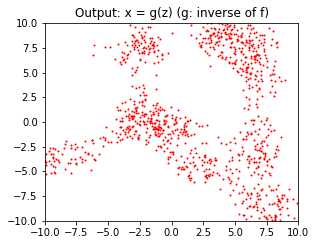

Train Epoch: 5 [0/50000 (0%)]	Loss: -0.021013
Train Epoch: 5 [6400/50000 (13%)]	Loss: -0.021782
Train Epoch: 5 [12800/50000 (26%)]	Loss: -0.022869
Train Epoch: 5 [19200/50000 (38%)]	Loss: -0.022498
Train Epoch: 5 [25600/50000 (51%)]	Loss: -0.021452
Train Epoch: 5 [32000/50000 (64%)]	Loss: -0.020983
Train Epoch: 5 [38400/50000 (77%)]	Loss: -0.022214
Train Epoch: 5 [44800/50000 (90%)]	Loss: -0.021160
====> Epoch: 5 Average train loss: -0.0219


<Figure size 432x288 with 0 Axes>

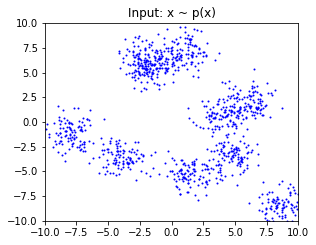

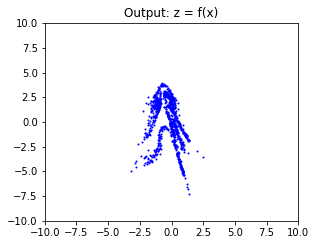

====> Test loss: -0.0033


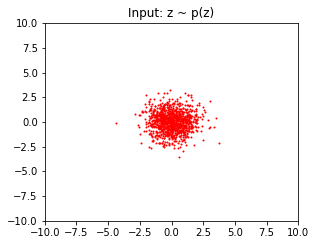

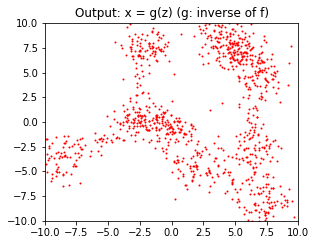

Train Epoch: 6 [0/50000 (0%)]	Loss: -0.021044
Train Epoch: 6 [6400/50000 (13%)]	Loss: -0.020948
Train Epoch: 6 [12800/50000 (26%)]	Loss: -0.019536
Train Epoch: 6 [19200/50000 (38%)]	Loss: -0.022095
Train Epoch: 6 [25600/50000 (51%)]	Loss: -0.022918
Train Epoch: 6 [32000/50000 (64%)]	Loss: -0.022491
Train Epoch: 6 [38400/50000 (77%)]	Loss: -0.021975
Train Epoch: 6 [44800/50000 (90%)]	Loss: -0.021911
====> Epoch: 6 Average train loss: -0.0220


<Figure size 432x288 with 0 Axes>

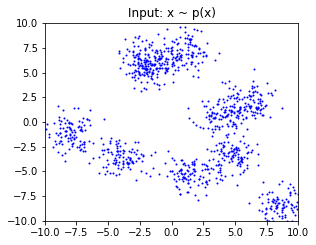

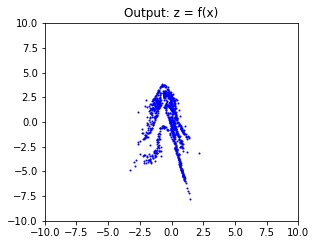

====> Test loss: -0.0012


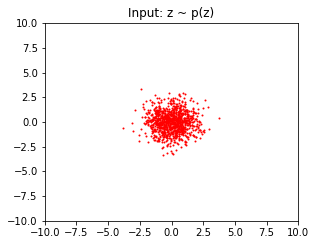

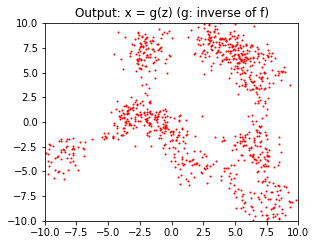

Train Epoch: 7 [0/50000 (0%)]	Loss: -0.022590
Train Epoch: 7 [6400/50000 (13%)]	Loss: -0.022186
Train Epoch: 7 [12800/50000 (26%)]	Loss: -0.022371
Train Epoch: 7 [19200/50000 (38%)]	Loss: -0.022477
Train Epoch: 7 [25600/50000 (51%)]	Loss: -0.022639
Train Epoch: 7 [32000/50000 (64%)]	Loss: -0.021303
Train Epoch: 7 [38400/50000 (77%)]	Loss: -0.022005
Train Epoch: 7 [44800/50000 (90%)]	Loss: -0.022037
====> Epoch: 7 Average train loss: -0.0221


<Figure size 432x288 with 0 Axes>

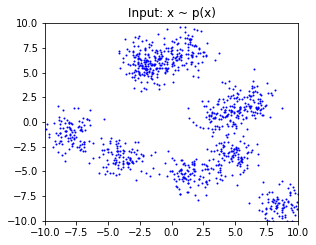

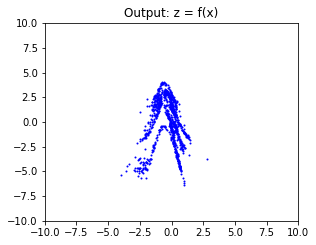

====> Test loss: -0.0011


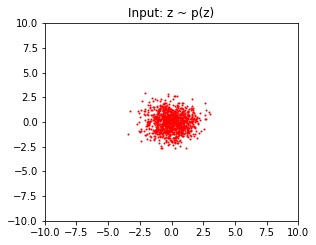

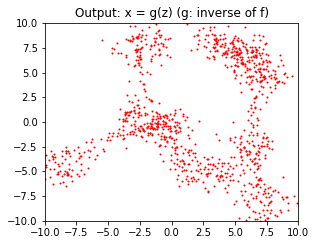

Train Epoch: 8 [0/50000 (0%)]	Loss: -0.022446
Train Epoch: 8 [6400/50000 (13%)]	Loss: -0.021843
Train Epoch: 8 [12800/50000 (26%)]	Loss: -0.022355
Train Epoch: 8 [19200/50000 (38%)]	Loss: -0.021646
Train Epoch: 8 [25600/50000 (51%)]	Loss: -0.022088
Train Epoch: 8 [32000/50000 (64%)]	Loss: -0.022534
Train Epoch: 8 [38400/50000 (77%)]	Loss: -0.022918
Train Epoch: 8 [44800/50000 (90%)]	Loss: -0.023003
====> Epoch: 8 Average train loss: -0.0221


<Figure size 432x288 with 0 Axes>

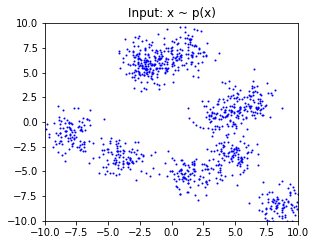

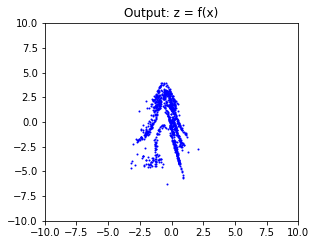

====> Test loss: -0.0033


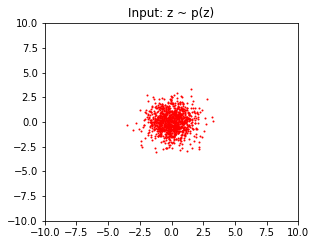

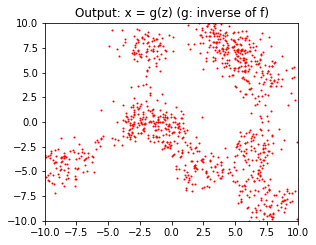

Train Epoch: 9 [0/50000 (0%)]	Loss: -0.022787
Train Epoch: 9 [6400/50000 (13%)]	Loss: -0.022311
Train Epoch: 9 [12800/50000 (26%)]	Loss: -0.023441
Train Epoch: 9 [19200/50000 (38%)]	Loss: -0.023008
Train Epoch: 9 [25600/50000 (51%)]	Loss: -0.022298
Train Epoch: 9 [32000/50000 (64%)]	Loss: -0.021987
Train Epoch: 9 [38400/50000 (77%)]	Loss: -0.021353
Train Epoch: 9 [44800/50000 (90%)]	Loss: -0.023194
====> Epoch: 9 Average train loss: -0.0222


<Figure size 432x288 with 0 Axes>

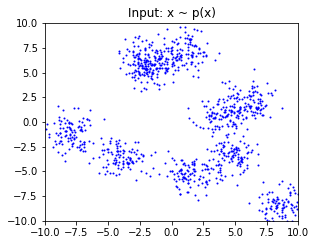

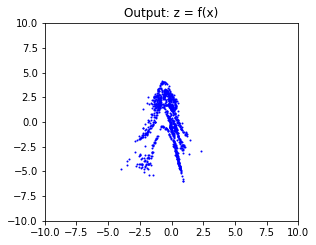

====> Test loss: -0.0006


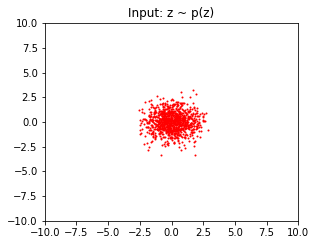

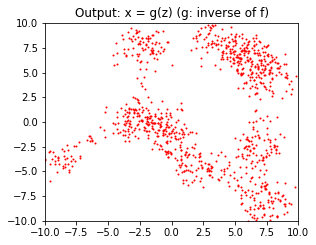

Train Epoch: 10 [0/50000 (0%)]	Loss: -0.022843
Train Epoch: 10 [6400/50000 (13%)]	Loss: -0.022147
Train Epoch: 10 [12800/50000 (26%)]	Loss: -0.022864
Train Epoch: 10 [19200/50000 (38%)]	Loss: -0.022526
Train Epoch: 10 [25600/50000 (51%)]	Loss: -0.023334
Train Epoch: 10 [32000/50000 (64%)]	Loss: -0.022749
Train Epoch: 10 [38400/50000 (77%)]	Loss: -0.022033
Train Epoch: 10 [44800/50000 (90%)]	Loss: -0.021898
====> Epoch: 10 Average train loss: -0.0223


<Figure size 432x288 with 0 Axes>

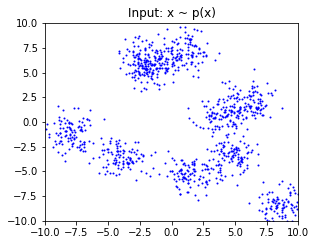

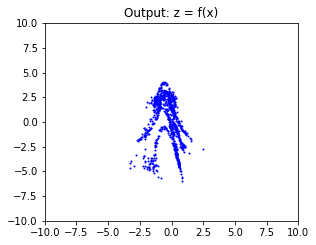

====> Test loss: -0.0013


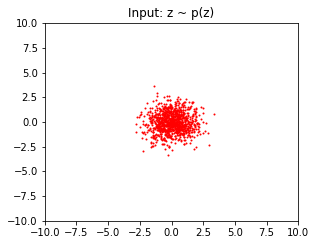

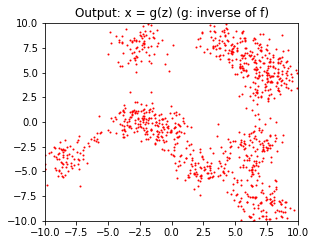

'154.51s'

<Figure size 432x288 with 0 Axes>

In [24]:
train_data = datasets.make_blobs(n_samples=50000, centers=10, n_features=2)[0].astype(np.float32)
test_data = datasets.make_blobs(n_samples=1000, centers=10, n_features=2)[0].astype(np.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)

# model construction
mask = torch.from_numpy(np.array([0, 1]).astype(np.float32))
model = RealNVP(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, mask, N_COUPLING_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
prior_z = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

# run
plot_args = (-10, 10, -10, 10)
start = timer()
for epoch in range(1, N_EPOCHS + 1):
    train(epoch, model, optimizer, prior_z, train_loader)
    test(epoch, model, prior_z, test_loader, plot_args)
    sample(epoch, model, prior_z, plot_args)
f"{timer() - start:.02f}s"

**Q20: As a conclusion, how would you compare the advantages and shortcomings of GANs, VAEs and Normalizing flows?**

> - **GANs**: The main advantage of GANs relies on the intuitive definition of the architecture which is well suited for the generative task. However, the main drawback of GANs is the training procedure which can be quite unstable as there is a "competition" between the optimization of the discriminator and the generator, leading to model that are hard to train. The second drawback that we also highlighted during this lab session is the problem of "modes drop" (cf. question 5), due to the fact that the loss which is used only gives feedback to the generator on samples it generated.
>
>
> - **VAEs**: In contrary to classic Auto-Encoder, VAEs provide a probabilistic framework that is designed as a generative model (where with classic Auto-Encoder, if we for example decode $z \sim \mathcal{N}(0,1)$, nothing ensure that we will actually decode it to a point this is in the initial training distribution as it hasn't been trained towards this objective). This probabilisitc framework thus allows to select a prior for the latent representation of the datapoints, which is another degree of freedom for the model expressivity (in addition to the choice of encoder/decoder depth and width). This is namely for example an advantage over normalizing flows where the latent space is a simple normal distribution. Nevertheless, the flexible formulation of the VAE requires to approximate maximum likelihood through amortised variational inference, so we only optimized a lower bound of the likelihood, and we got slightly worse results than with GAN (but that might be dependant on the dataset which is considered).
>
>
> - **Normalizing Flows**: Normalizing Flows best advantage is to be able to have an explicit formulation of the likelihood, thanks to the invertibility of the mapping which is used, thus providing an explicit criterion to optimize which is based on the Jacobian of this mapping. This might also help in some form of interpretation as by knowing the latent variable $z$, we know deterministically the datapoint which is generated $x$ and conversely. However, a first drawback is that this modelisation require more effort to design invertible functions that remain flexible enough (here we saw the example of the coupling layers but other design like making use of residual nets and Lipschitzianity has also been an explored idea in the litterature). A second drawback is related to the analysis we made in Question 19, which comes from the fact that the latent distribution which is used, a normal distribution, might not be expressive enough in the case of a data distribution which would corresponds to many clusters.

Thanks for reading!